In [1]:
import os
import torch
import numpy as np
import pandas as pd

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, utils
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt


In [2]:
available = torch.cuda.is_available()
curr_device = torch.cuda.current_device()
device = torch.device("cuda:0" if available else "cpu")
device_count = torch.cuda.device_count() 
device_name =  torch.cuda.get_device_name(0)

print(f'Cuda available: {available}')
print(f'Current device: {curr_device}')
print(f'Device: {device}')
print(f'Device count: {device_count}')
print(f'Device name: {device_name}')

Cuda available: True
Current device: 0
Device: cuda:0
Device count: 1
Device name: GeForce GTX 1070


In [3]:
# (Adapted) Code from PyTorch's Resnet impl: https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py

def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.utils.weight_norm(nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    ))

class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            # norm_layer = nn.BatchNorm2d
            norm_layer = nn.InstanceNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [4]:
class MyBatchNorm2d(nn.modules.batchnorm._NormBase):
    ''' Partially based on: 
        https://pytorch.org/docs/stable/_modules/torch/nn/modules/batchnorm.html#BatchNorm2d
        https://discuss.pytorch.org/t/implementing-batchnorm-in-pytorch-problem-with-updating-self-running-mean-and-self-running-var/49314/5 
    '''
    def __init__(
        self,
        num_features,
        eps=1e-5,
        momentum=0.005,
        device=None,
        dtype=None
    ):
        factory_kwargs = {'device': device, 'dtype': dtype, 'affine': False, 'track_running_stats': True}
        super(MyBatchNorm2d, self).__init__(
            num_features, eps, momentum, **factory_kwargs
        )
        
    def _check_input_dim(self, input):
        if input.dim() != 4:
            raise ValueError("expected 4D input (got {}D input)".format(input.dim()))

    def forward(self, input, validation=False):
        self._check_input_dim(input)
    
        if self.training:
            # Note: Need to detatch `running_{mean,var}` so don't backwards propagate through them
            unbiased_var, tmean = torch.var_mean(input, [0, 2, 3], unbiased=True)
            mean = torch.mean(input, [0, 2, 3]) # along channel axis
            unbiased_var = torch.var(input, [0, 2, 3], unbiased=True) # along channel axis
            running_mean = (1.0 - self.momentum) * self.running_mean.detach() + self.momentum * mean
            
            # Strange: PyTorch impl. of running variance uses biased_variance for the batch calc but
            # *unbiased_var* for the running_var!
            # https://github.com/pytorch/pytorch/blob/master/aten/src/ATen/native/Normalization.cpp#L190
            running_var = (1.0 - self.momentum) * self.running_var.detach() + self.momentum * unbiased_var
            
            # BK: Modification from the paper to use running mean/var instead of batch mean/var
            # change shape
            current_mean = running_mean.view([1, self.num_features, 1, 1]).expand_as(input)
            current_var = running_var.view([1, self.num_features, 1, 1]).expand_as(input)
            
            denom = (current_var + self.eps)
            y = (input - current_mean) / denom.sqrt()
            
            self.running_mean = running_mean
            self.running_var = running_var
            
            return y, -0.5 * torch.log(denom)
        else:
            current_mean = self.running_mean.view([1, self.num_features, 1, 1]).expand_as(input)
            current_var = self.running_var.view([1, self.num_features, 1, 1]).expand_as(input)
            
            if validation:
                denom = (current_var + self.eps)
                y = (input - current_mean) / denom.sqrt()
            else:
                # Reverse operation for testing
                denom = (current_var + self.eps)
                y = input * denom.sqrt() + current_mean
                
            return y, -0.5 * torch.log(denom)

In [5]:
def bottleneck_backbone(in_planes, planes):
    return nn.Sequential(
        conv3x3(in_planes, planes),
        nn.InstanceNorm2d(planes),
        BasicBlock(planes, planes),
        BasicBlock(planes, planes),
        conv3x3(planes, in_planes),
        nn.InstanceNorm2d(planes),
    )

check_mask = {}
check_mask_device = {}
def checkerboard_mask(shape, to_device=True):
    global check_mask, check_mask_device
    if shape not in check_mask:
        check_mask[shape] = 1 - np.indices(shape).sum(axis=0) % 2
        check_mask[shape] = torch.Tensor(check_mask[shape])
        
    if to_device and shape not in check_mask_device:
        check_mask_device[shape] = check_mask[shape].to(device)
        
    return check_mask_device[shape] if to_device else check_mask[shape]

chan_mask = {}
chan_mask_device = {}
def channel_mask(shape, to_device=True):
    assert len(shape) == 3, shape
    assert shape[0] % 2 == 0, shape
    global chan_mask, chan_mask_device
    if shape not in chan_mask:
        chan_mask[shape] = torch.cat([torch.zeros((shape[0] // 2, shape[1], shape[2])),
                                      torch.ones((shape[0] // 2, shape[1], shape[2])),],
                                      dim=0)
        assert chan_mask[shape].shape == shape, (chan_mask[shape].shape, shape)
        
    if to_device and shape not in chan_mask_device:
        chan_mask_device[shape] = chan_mask[shape].to(device)
        
    return chan_mask_device[shape] if to_device else chan_mask[shape]

In [6]:
class NormalizingFlow(nn.Module):
    EPSILON = 1e-5
    
    def __init__(self, num_coupling=6, num_final_coupling=4, planes=64):
        super(NormalizingFlow, self).__init__()
        self.num_coupling = num_coupling
        self.num_final_coupling = num_final_coupling
        self.shape = (3, 64, 64)
        
        self.planes = planes
        self.s = nn.ModuleList()
        self.t = nn.ModuleList()
        self.norms = nn.ModuleList()
        
        # Learnable scalar scaling parameters for outputs of S and T
        self.s_scale = nn.ParameterList()
        self.t_scale = nn.ParameterList()
        self.t_bias = nn.ParameterList()
        self.shapes = []
      
        shape = self.shape
        for i in range(num_coupling):
            self.s.append(bottleneck_backbone(shape[0], planes))
            self.t.append(bottleneck_backbone(shape[0], planes))
            
            self.s_scale.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))
            self.t_scale.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))
            self.t_bias.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))
            
            self.norms.append(MyBatchNorm2d(shape[0]))
            
            self.shapes.append(shape)
           
            if i % 6 == 2:
                shape = (4 * shape[0], shape[1] // 2, shape[2] // 2)
                
            if i % 6 == 5:
                # Factoring out half the channels
                shape = (shape[0] // 2, shape[1], shape[2])
                planes = 2 * planes
       
        # Final coupling layers checkerboard
        for i in range(num_final_coupling):
            self.s.append(bottleneck_backbone(shape[0], planes))
            self.t.append(bottleneck_backbone(shape[0], planes))
            
            self.s_scale.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))
            self.t_scale.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))
            self.t_bias.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))
            
            self.norms.append(MyBatchNorm2d(shape[0]))
            
            self.shapes.append(shape)
           
        self.validation = False
    
    def validate(self):
        self.eval()
        self.validation = True
        
    def train(self, mode=True):
        nn.Module.train(self, mode)
        self.validation = False

    def forward(self, x):
        if self.training or self.validation:
            s_vals = []
            norm_vals = []
            y_vals = []
            
            for i in range(self.num_coupling):
                shape = self.shapes[i]
                mask = checkerboard_mask(shape) if i % 6 < 3 else channel_mask(shape)
                mask = mask if i % 2 == 0 else (1 - mask)
               
                t = (self.t_scale[i]) * self.t[i](mask * x) + (self.t_bias[i])
                s = (self.s_scale[i]) * torch.tanh(self.s[i](mask * x))
                y = mask * x + (1 - mask) * (x * torch.exp(s) + t)
                s_vals.append(torch.flatten((1 - mask) * s))
               
                if self.norms[i] is not None:
                    y, norm_loss = self.norms[i](y, validation=self.validation)
                    norm_vals.append(norm_loss)
                    
                if i % 6 == 2:
                    y = torch.nn.functional.pixel_unshuffle(y, 2)
                    
                if i % 6 == 5:
                    factor_channels = y.shape[1] // 2
                    y_vals.append(torch.flatten(y[:, factor_channels:, :, :], 1))
                    y = y[:, :factor_channels, :, :]
                    
                x = y
                
            # Final checkboard coupling
            for i in range(self.num_coupling, self.num_coupling + self.num_final_coupling):
                shape = self.shapes[i]
                mask = checkerboard_mask(shape)
                mask = mask if i % 2 == 0 else (1 - mask)
               
                t = (self.t_scale[i]) * self.t[i](mask * x) + (self.t_bias[i])
                s = (self.s_scale[i]) * torch.tanh(self.s[i](mask * x))
                y = mask * x + (1 - mask) * (x * torch.exp(s) + t)
                s_vals.append(torch.flatten((1 - mask) * s))
                
                if self.norms[i] is not None:
                    y, norm_loss = self.norms[i](y, validation=self.validation)
                    norm_vals.append(norm_loss)
                
                x = y

            y_vals.append(torch.flatten(y, 1))
            
            # Return outputs and vars needed for determinant
            return (torch.flatten(torch.cat(y_vals, 1), 1),
                    torch.cat(s_vals), 
                    torch.cat([torch.flatten(v) for v in norm_vals]) if len(norm_vals) > 0 else torch.zeros(1),
                    torch.cat([torch.flatten(s) for s in self.s_scale]))
        else:
            y = x
            y_remaining = y
           
            layer_vars = np.prod(self.shapes[-1])
            y = torch.reshape(y_remaining[:, -layer_vars:], (-1,) + self.shapes[-1])
            y_remaining = y_remaining[:, :-layer_vars]
            
            # Reversed final checkboard coupling
            for i in reversed(range(self.num_coupling, self.num_coupling + self.num_final_coupling)):
                shape = self.shapes[i]
                mask = checkerboard_mask(shape)
                mask = mask if i % 2 == 0 else (1 - mask)
                
                if self.norms[i] is not None:
                    y, _ = self.norms[i](y)
              
                t = (self.t_scale[i]) * self.t[i](mask * y) + (self.t_bias[i])
                s = (self.s_scale[i]) * torch.tanh(self.s[i](mask * y))
                x = mask * y + (1 - mask) * ((y - t) * torch.exp(-s))
               
                y = x           
          
            layer_vars = np.prod(shape)
            y = torch.cat((y, torch.reshape(y_remaining[:, -layer_vars:], (-1,) + shape)), 1)
            y_remaining = y_remaining[:, :-layer_vars]
            
            # Multi-scale coupling layers
            for i in reversed(range(self.num_coupling)):
                shape = self.shapes[i]
                mask = checkerboard_mask(shape) if i % 6 < 3 else channel_mask(shape)
                mask = mask if i % 2 == 0 else (1 - mask)
              
                if self.norms[i] is not None:
                    y, _ = self.norms[i](y)
                    
                t = (self.t_scale[i]) * self.t[i](mask * y) + (self.t_bias[i])
                s = (self.s_scale[i]) * torch.tanh(self.s[i](mask * y))
                x = mask * y + (1 - mask) * ((y - t) * torch.exp(-s))
               
                if i % 6 == 3:
                    x = torch.nn.functional.pixel_shuffle(x, 2)
                    
                y = x
                
                if i > 0 and i % 6 == 0:
                    layer_vars = np.prod(shape)
                    y = torch.cat((y, torch.reshape(y_remaining[:, -layer_vars:], (-1,) + shape)), 1)
                    y_remaining = y_remaining[:, :-layer_vars]
            
            assert np.prod(y_remaining.shape) == 0
            
            return x

In [7]:
PI = torch.tensor(np.pi).to(device)
def loss_fn(y, s, norms, scale, batch_size):
    # -log(zero-mean gaussian) + log determinant
    # -log p_x = log(pz(f(x))) + log(det(\partial f/\partial x))
    # -log p_x = 0.5 * y**2 + s1 + s2 + ... + batch_norm_scalers + l2_regularizers(scale)
    logpx = -torch.sum(0.5 * torch.log(2 * PI) + 0.5 * y**2)
    det = torch.sum(s)
    norms = torch.sum(norms)
    reg = 5e-5 * torch.sum(scale ** 2)
    loss = -(logpx + det + norms) + reg
    return torch.div(loss, batch_size), (-logpx, -det, -norms, reg)

# Training

In [8]:
def pre_process(x):
    # Convert back to integer values
    x = x * 255.
    
    # Add random uniform [0, 1] noise to get a proper likelihood estimate
    # https://bjlkeng.github.io/posts/a-note-on-using-log-likelihood-for-generative-models/
    x = x + torch.rand(x.shape)

    # Apply transform to deal with boundary effects (see realNVP paper)
    x = torch.logit(0.05 + 0.90 * x / 256)
    return x
    #return x / 255

def post_process(x):
    # Convert back to integer values
    return torch.clip(torch.floor(256 / 0.90 * (torch.sigmoid(x) - 0.05)), min=0, max=255) / 255
    #return torch.clip(x, min=0, max=1)
    
def log_preprocessing_grad(y):
    # Used to adjust for pixel preprocessing
    # log(grad(pre_processing))
    # = log(grad(logit(0.9 / 256 * x + 0.05)))
    
    # Assume input is y = pre_process(x)
    x = 256 / 0.90 * (torch.sigmoid(y) - 0.05)
    arg = 0.9 * x / 256 + 0.05
    return torch.log(1 / arg + 1 / (1 - arg)) + np.log(0.9 / 256)

In [9]:
train_dataset = datasets.CelebA('data', split='train', download=False,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.CenterCrop(size=148),
                                   transforms.Resize(size=64),
                                   transforms.RandomHorizontalFlip(p=0.5)
                               ]))

# TODO FIX ME
debug_data = []
for i, x in enumerate(train_dataset):
    if i >= 20*2:
        break
    debug_data.append(x)

test_dataset = datasets.CelebA('data', split='valid', download=False,
                              transform=transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.CenterCrop(size=148),
                                  transforms.Resize(size=64),
                              ]))

In [10]:
def train_loop(dataloader, model, loss_fn, optimizer, batch_size, report_iters=10, num_pixels=64*64*3):
    size = len(dataloader)
    avg_loss = 0
    for batch, (X, _) in enumerate(dataloader):
        # Transfer to GPU
        X = pre_process(X)
        X = X.to(device)
        
        # Compute prediction and loss
        y, s, norms, scale = model(X)
        loss, comps = loss_fn(y, s, norms, scale, batch_size)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        loss, current = loss.item(), batch
        # Account for preprocessing
        loss -= torch.sum(log_preprocessing_grad(X)) / batch_size
        avg_loss += loss
        
        if batch % report_iters == 0:
            print(f"loss: {loss:.2f} = -logpx[{comps[0]:.1f}], -det[{comps[1]:.1f}], -norms[{comps[2]:.1f}], reg[{comps[3]:.4f}]"
                  f"; bits/pixel: {loss / num_pixels / np.log(2):>.2f}  [{current:>5d}/{size:>5d}]")
        
    avg_loss = avg_loss / (batch + 1)
    print(f"Train Error: \n Avg loss: {avg_loss:.2f}; {avg_loss / num_pixels / np.log(2):.2f} \n")
    
    return avg_loss / num_pixels / np.log(2)
            
        
def test_loop(dataloader, model, loss_fn, num_pixels=64*64*3):
    size = len(dataloader)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        model.validate()
        for X, _ in dataloader:
            X = pre_process(X)
            X = X.to(device)
            y, s, norms, scale = model(X)
            loss, _ = loss_fn(y, s, norms, scale, batch_size)
            test_loss += loss
            test_loss -= torch.sum(log_preprocessing_grad(X)) / batch_size
        model.train()

    test_loss /= num_batches
    # Account for preprocessing
    print(f"Test Error: \n Avg loss: {test_loss:.2f}; {test_loss / num_pixels / np.log(2):.2f} \n")
    return test_loss, test_loss / num_pixels / np.log(2)

In [11]:
learning_rate = 0.0005
batch_size = 20
epochs = 10

In [12]:
model = NormalizingFlow(num_coupling=24, num_final_coupling=4, planes=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.5)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

PATH = 'checkpoints/'
best_validation = None
best_path = None
for t in range(epochs):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    #train_loader = DataLoader(debug_data, batch_size=batch_size, shuffle=True)
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_loader, model, loss_fn, optimizer, batch_size)
    validation_loss, validation_bpp = test_loop(test_loader, model, loss_fn)

    if best_validation is None or validation_bpp < best_validation:
        best_validation = validation_bpp
        best_path = PATH + f'celeba-{t + 1}.model'
        torch.save({
            'epoch': t + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': validation_loss,
        }, PATH + f'celeba-{t + 1}.model')
    scheduler.step()

print("Done - ", best_path, " = ", best_validation)

Epoch 1
-------------------------------
loss: 69993.19 = -logpx[446442.8], -det[-0.0], -norms[4569.8], reg[0.0000]; bits/pixel: 8.22  [    0/ 8139]
loss: 68274.71 = -logpx[381352.7], -det[635.3], -norms[38226.2], reg[0.0001]; bits/pixel: 8.02  [   10/ 8139]
loss: 67247.48 = -logpx[346304.7], -det[-423.5], -norms[47633.9], reg[0.0002]; bits/pixel: 7.90  [   20/ 8139]
loss: 66556.20 = -logpx[321353.6], -det[-1672.4], -norms[50512.0], reg[0.0005]; bits/pixel: 7.81  [   30/ 8139]
loss: 65565.66 = -logpx[314587.8], -det[-3703.1], -norms[47749.2], reg[0.0009]; bits/pixel: 7.70  [   40/ 8139]
loss: 65744.39 = -logpx[326969.4], -det[-4889.0], -norms[44827.3], reg[0.0014]; bits/pixel: 7.72  [   50/ 8139]
loss: 65785.23 = -logpx[339938.4], -det[-4881.2], -norms[36428.0], reg[0.0021]; bits/pixel: 7.72  [   60/ 8139]
loss: 64662.83 = -logpx[336828.8], -det[-6813.2], -norms[26873.1], reg[0.0030]; bits/pixel: 7.59  [   70/ 8139]
loss: 64303.90 = -logpx[328571.8], -det[-6448.6], -norms[14621.1], reg[

loss: 43035.18 = -logpx[363226.2], -det[4945.1], -norms[-474563.5], reg[0.2246]; bits/pixel: 5.05  [  720/ 8139]
loss: 40644.42 = -logpx[326278.0], -det[12870.2], -norms[-475988.6], reg[0.2281]; bits/pixel: 4.77  [  730/ 8139]
loss: 41300.34 = -logpx[340749.1], -det[19995.5], -norms[-484226.7], reg[0.2309]; bits/pixel: 4.85  [  740/ 8139]
loss: 40970.22 = -logpx[333539.2], -det[23765.4], -norms[-483766.0], reg[0.2339]; bits/pixel: 4.81  [  750/ 8139]
loss: 41661.80 = -logpx[348275.6], -det[19428.4], -norms[-491037.6], reg[0.2369]; bits/pixel: 4.89  [  760/ 8139]
loss: 41867.36 = -logpx[346858.7], -det[26719.9], -norms[-493727.0], reg[0.2400]; bits/pixel: 4.92  [  770/ 8139]
loss: 39765.43 = -logpx[333338.5], -det[10855.9], -norms[-499760.7], reg[0.2428]; bits/pixel: 4.67  [  780/ 8139]
loss: 41672.91 = -logpx[357989.1], -det[52760.1], -norms[-504400.2], reg[0.2455]; bits/pixel: 4.89  [  790/ 8139]
loss: 40902.73 = -logpx[347049.3], -det[20518.3], -norms[-505673.8], reg[0.2485]; bits/pi

loss: 37871.16 = -logpx[345328.5], -det[57976.6], -norms[-592133.4], reg[0.4133]; bits/pixel: 4.45  [ 1440/ 8139]
loss: 37441.32 = -logpx[344552.2], -det[41267.9], -norms[-587612.4], reg[0.4156]; bits/pixel: 4.40  [ 1450/ 8139]
loss: 37039.38 = -logpx[343110.6], -det[44104.4], -norms[-586261.4], reg[0.4178]; bits/pixel: 4.35  [ 1460/ 8139]
loss: 36691.87 = -logpx[341884.4], -det[39783.6], -norms[-592111.6], reg[0.4197]; bits/pixel: 4.31  [ 1470/ 8139]
loss: 44000.28 = -logpx[481012.6], -det[58366.4], -norms[-587254.6], reg[0.4214]; bits/pixel: 5.17  [ 1480/ 8139]
loss: 36072.39 = -logpx[331000.9], -det[45452.0], -norms[-596222.2], reg[0.4237]; bits/pixel: 4.24  [ 1490/ 8139]
loss: 36361.76 = -logpx[340375.4], -det[36104.1], -norms[-604669.8], reg[0.4254]; bits/pixel: 4.27  [ 1500/ 8139]
loss: 35784.77 = -logpx[342298.2], -det[26459.0], -norms[-603318.4], reg[0.4273]; bits/pixel: 4.20  [ 1510/ 8139]
loss: 38025.77 = -logpx[357214.4], -det[58036.5], -norms[-607174.6], reg[0.4293]; bits/p

loss: 35865.11 = -logpx[343975.3], -det[78360.4], -norms[-657159.1], reg[0.5462]; bits/pixel: 4.21  [ 2160/ 8139]
loss: 34871.72 = -logpx[357459.6], -det[40274.2], -norms[-656584.0], reg[0.5479]; bits/pixel: 4.09  [ 2170/ 8139]
loss: 36443.40 = -logpx[352325.2], -det[80707.1], -norms[-656277.0], reg[0.5496]; bits/pixel: 4.28  [ 2180/ 8139]
loss: 36049.98 = -logpx[350792.3], -det[84654.5], -norms[-657882.6], reg[0.5513]; bits/pixel: 4.23  [ 2190/ 8139]
loss: 35410.68 = -logpx[337122.4], -det[75515.0], -norms[-650056.5], reg[0.5533]; bits/pixel: 4.16  [ 2200/ 8139]
loss: 35682.16 = -logpx[366647.4], -det[48547.3], -norms[-653275.5], reg[0.5554]; bits/pixel: 4.19  [ 2210/ 8139]
loss: 34717.42 = -logpx[341238.8], -det[59095.2], -norms[-648977.5], reg[0.5573]; bits/pixel: 4.08  [ 2220/ 8139]
loss: 35571.82 = -logpx[351293.7], -det[53859.6], -norms[-649081.8], reg[0.5591]; bits/pixel: 4.18  [ 2230/ 8139]
loss: 35927.79 = -logpx[347214.2], -det[76084.5], -norms[-653612.5], reg[0.5606]; bits/p

loss: 35861.16 = -logpx[348637.1], -det[101323.8], -norms[-663199.2], reg[0.6628]; bits/pixel: 4.21  [ 2880/ 8139]
loss: 35089.80 = -logpx[343864.7], -det[58105.5], -norms[-660168.4], reg[0.6644]; bits/pixel: 4.12  [ 2890/ 8139]
loss: 34226.18 = -logpx[346362.2], -det[56506.1], -norms[-659894.8], reg[0.6658]; bits/pixel: 4.02  [ 2900/ 8139]
loss: 35158.11 = -logpx[349087.3], -det[52644.6], -norms[-660732.3], reg[0.6671]; bits/pixel: 4.13  [ 2910/ 8139]
loss: 34067.32 = -logpx[343009.3], -det[45301.8], -norms[-662567.5], reg[0.6683]; bits/pixel: 4.00  [ 2920/ 8139]
loss: 33673.58 = -logpx[344818.2], -det[31809.6], -norms[-666648.8], reg[0.6695]; bits/pixel: 3.95  [ 2930/ 8139]
loss: 33545.97 = -logpx[341279.2], -det[59376.9], -norms[-670536.9], reg[0.6708]; bits/pixel: 3.94  [ 2940/ 8139]
loss: 36362.38 = -logpx[356208.4], -det[89697.0], -norms[-666520.9], reg[0.6720]; bits/pixel: 4.27  [ 2950/ 8139]
loss: 34347.71 = -logpx[344048.9], -det[62356.4], -norms[-670004.2], reg[0.6735]; bits/

loss: 34302.02 = -logpx[353972.7], -det[34327.1], -norms[-661180.8], reg[0.7719]; bits/pixel: 4.03  [ 3600/ 8139]
loss: 33394.30 = -logpx[340232.4], -det[28039.4], -norms[-663330.5], reg[0.7734]; bits/pixel: 3.92  [ 3610/ 8139]
loss: 38230.94 = -logpx[396641.6], -det[64111.4], -norms[-645481.0], reg[0.7751]; bits/pixel: 4.49  [ 3620/ 8139]
loss: 36626.91 = -logpx[343592.6], -det[99177.5], -norms[-638751.2], reg[0.7769]; bits/pixel: 4.30  [ 3630/ 8139]
loss: 36038.07 = -logpx[348319.8], -det[62023.0], -norms[-634593.1], reg[0.7783]; bits/pixel: 4.23  [ 3640/ 8139]
loss: 34306.12 = -logpx[337206.2], -det[38928.3], -norms[-635948.6], reg[0.7796]; bits/pixel: 4.03  [ 3650/ 8139]
loss: 33158.92 = -logpx[332687.1], -det[24376.7], -norms[-639471.2], reg[0.7808]; bits/pixel: 3.89  [ 3660/ 8139]
loss: 34441.88 = -logpx[343112.8], -det[42929.0], -norms[-645337.6], reg[0.7820]; bits/pixel: 4.04  [ 3670/ 8139]
loss: 35039.89 = -logpx[345916.7], -det[56420.2], -norms[-640830.1], reg[0.7835]; bits/p

loss: 34256.59 = -logpx[345099.1], -det[9677.0], -norms[-630595.1], reg[0.8859]; bits/pixel: 4.02  [ 4320/ 8139]
loss: 34718.23 = -logpx[349238.3], -det[28420.4], -norms[-626804.1], reg[0.8876]; bits/pixel: 4.08  [ 4330/ 8139]
loss: 34639.65 = -logpx[352796.0], -det[20896.1], -norms[-628204.2], reg[0.8893]; bits/pixel: 4.07  [ 4340/ 8139]
loss: 34034.31 = -logpx[347818.6], -det[13195.1], -norms[-629772.1], reg[0.8907]; bits/pixel: 4.00  [ 4350/ 8139]
loss: 33029.40 = -logpx[343609.8], -det[-1824.5], -norms[-629158.9], reg[0.8923]; bits/pixel: 3.88  [ 4360/ 8139]
loss: 33208.00 = -logpx[342645.8], -det[6009.9], -norms[-631688.2], reg[0.8938]; bits/pixel: 3.90  [ 4370/ 8139]
loss: 33868.01 = -logpx[346663.3], -det[-375.9], -norms[-627988.9], reg[0.8956]; bits/pixel: 3.98  [ 4380/ 8139]
loss: 34122.90 = -logpx[346374.5], -det[22025.7], -norms[-629636.2], reg[0.8973]; bits/pixel: 4.01  [ 4390/ 8139]
loss: 33687.80 = -logpx[346334.2], -det[-2830.4], -norms[-628792.7], reg[0.8991]; bits/pixe

loss: 32128.32 = -logpx[341601.7], -det[-663.7], -norms[-640559.2], reg[0.9937]; bits/pixel: 3.77  [ 5040/ 8139]
loss: 33152.51 = -logpx[351466.2], -det[-5499.4], -norms[-642107.6], reg[0.9948]; bits/pixel: 3.89  [ 5050/ 8139]
loss: 33429.59 = -logpx[346060.9], -det[15134.2], -norms[-632494.1], reg[0.9967]; bits/pixel: 3.92  [ 5060/ 8139]
loss: 32981.15 = -logpx[341446.4], -det[8125.2], -norms[-637740.2], reg[0.9983]; bits/pixel: 3.87  [ 5070/ 8139]
loss: 34626.69 = -logpx[352875.4], -det[32995.1], -norms[-640024.8], reg[0.9995]; bits/pixel: 4.07  [ 5080/ 8139]
loss: 34222.23 = -logpx[348442.5], -det[26535.0], -norms[-635489.0], reg[1.0010]; bits/pixel: 4.02  [ 5090/ 8139]
loss: 33829.77 = -logpx[346934.4], -det[-3815.0], -norms[-633623.0], reg[1.0025]; bits/pixel: 3.97  [ 5100/ 8139]
loss: 34526.72 = -logpx[357674.1], -det[19578.4], -norms[-634112.2], reg[1.0039]; bits/pixel: 4.05  [ 5110/ 8139]
loss: 33864.09 = -logpx[344135.9], -det[25981.1], -norms[-626386.1], reg[1.0057]; bits/pix

loss: 33085.03 = -logpx[345845.0], -det[-17777.7], -norms[-623617.0], reg[1.0885]; bits/pixel: 3.88  [ 5760/ 8139]
loss: 34139.04 = -logpx[354938.9], -det[-1201.2], -norms[-627937.3], reg[1.0895]; bits/pixel: 4.01  [ 5770/ 8139]
loss: 33275.87 = -logpx[354878.2], -det[-1973.2], -norms[-627632.2], reg[1.0910]; bits/pixel: 3.91  [ 5780/ 8139]
loss: 32886.84 = -logpx[348567.4], -det[-12870.5], -norms[-631156.5], reg[1.0923]; bits/pixel: 3.86  [ 5790/ 8139]
loss: 33388.62 = -logpx[358451.4], -det[6471.5], -norms[-632262.7], reg[1.0934]; bits/pixel: 3.92  [ 5800/ 8139]
loss: 31347.82 = -logpx[347342.5], -det[-33326.9], -norms[-638794.5], reg[1.0948]; bits/pixel: 3.68  [ 5810/ 8139]
loss: 32781.91 = -logpx[342833.5], -det[20052.0], -norms[-639835.4], reg[1.0959]; bits/pixel: 3.85  [ 5820/ 8139]
loss: 32451.61 = -logpx[349506.1], -det[-23538.4], -norms[-643504.2], reg[1.0972]; bits/pixel: 3.81  [ 5830/ 8139]
loss: 33891.93 = -logpx[353768.5], -det[17553.0], -norms[-645312.6], reg[1.0984]; bit

loss: 32884.50 = -logpx[347235.6], -det[12375.6], -norms[-652024.4], reg[1.1740]; bits/pixel: 3.86  [ 6480/ 8139]
loss: 31826.31 = -logpx[342905.9], -det[-9907.2], -norms[-653434.2], reg[1.1747]; bits/pixel: 3.74  [ 6490/ 8139]
loss: 32434.37 = -logpx[347459.5], -det[-3433.5], -norms[-656848.1], reg[1.1756]; bits/pixel: 3.81  [ 6500/ 8139]
loss: 30683.78 = -logpx[343315.1], -det[-15069.0], -norms[-656810.8], reg[1.1766]; bits/pixel: 3.60  [ 6510/ 8139]
loss: 31730.30 = -logpx[347943.6], -det[886.7], -norms[-657946.0], reg[1.1775]; bits/pixel: 3.73  [ 6520/ 8139]
loss: 33100.44 = -logpx[352759.5], -det[9479.8], -norms[-663237.5], reg[1.1783]; bits/pixel: 3.89  [ 6530/ 8139]
loss: 33920.78 = -logpx[355260.9], -det[41172.3], -norms[-660070.1], reg[1.1794]; bits/pixel: 3.98  [ 6540/ 8139]
loss: 31939.00 = -logpx[339880.7], -det[8213.4], -norms[-662256.4], reg[1.1807]; bits/pixel: 3.75  [ 6550/ 8139]
loss: 31581.76 = -logpx[343305.0], -det[-12250.0], -norms[-660945.8], reg[1.1820]; bits/pix

loss: 32379.05 = -logpx[350886.8], -det[21754.3], -norms[-673254.2], reg[1.2452]; bits/pixel: 3.80  [ 7200/ 8139]
loss: 31699.38 = -logpx[340322.3], -det[22562.3], -norms[-672770.3], reg[1.2462]; bits/pixel: 3.72  [ 7210/ 8139]
loss: 32492.04 = -logpx[348122.9], -det[27405.5], -norms[-668652.8], reg[1.2472]; bits/pixel: 3.81  [ 7220/ 8139]
loss: 31050.14 = -logpx[342052.4], -det[10209.1], -norms[-667453.1], reg[1.2485]; bits/pixel: 3.65  [ 7230/ 8139]
loss: 32614.95 = -logpx[341509.3], -det[25734.7], -norms[-663598.5], reg[1.2496]; bits/pixel: 3.83  [ 7240/ 8139]
loss: 31711.45 = -logpx[345032.2], -det[2350.6], -norms[-665170.8], reg[1.2507]; bits/pixel: 3.72  [ 7250/ 8139]
loss: 33342.23 = -logpx[353359.1], -det[45397.1], -norms[-664028.5], reg[1.2515]; bits/pixel: 3.91  [ 7260/ 8139]
loss: 32590.95 = -logpx[349655.8], -det[16156.5], -norms[-663834.9], reg[1.2522]; bits/pixel: 3.83  [ 7270/ 8139]
loss: 32623.38 = -logpx[356079.6], -det[5371.9], -norms[-663426.5], reg[1.2531]; bits/pix

loss: 32108.52 = -logpx[350833.1], -det[58651.4], -norms[-687543.0], reg[1.3106]; bits/pixel: 3.77  [ 7920/ 8139]
loss: 31181.18 = -logpx[347927.8], -det[12285.0], -norms[-686886.0], reg[1.3118]; bits/pixel: 3.66  [ 7930/ 8139]
loss: 31393.59 = -logpx[341765.3], -det[32267.5], -norms[-685643.2], reg[1.3128]; bits/pixel: 3.69  [ 7940/ 8139]
loss: 31160.06 = -logpx[345518.8], -det[9927.8], -norms[-684425.1], reg[1.3139]; bits/pixel: 3.66  [ 7950/ 8139]
loss: 30713.24 = -logpx[335894.9], -det[4108.8], -norms[-686785.1], reg[1.3150]; bits/pixel: 3.61  [ 7960/ 8139]
loss: 31815.00 = -logpx[345268.2], -det[22300.4], -norms[-689343.1], reg[1.3159]; bits/pixel: 3.74  [ 7970/ 8139]
loss: 30696.72 = -logpx[344343.8], -det[-4416.2], -norms[-689151.9], reg[1.3169]; bits/pixel: 3.60  [ 7980/ 8139]
loss: 31860.60 = -logpx[351376.8], -det[31727.8], -norms[-687646.8], reg[1.3178]; bits/pixel: 3.74  [ 7990/ 8139]
loss: 31819.91 = -logpx[350464.9], -det[16769.2], -norms[-690129.1], reg[1.3186]; bits/pix

loss: 31211.69 = -logpx[345643.9], -det[29793.9], -norms[-701840.6], reg[1.3745]; bits/pixel: 3.66  [  490/ 8139]
loss: 30899.85 = -logpx[348396.4], -det[25390.6], -norms[-702790.5], reg[1.3752]; bits/pixel: 3.63  [  500/ 8139]
loss: 31146.34 = -logpx[341825.4], -det[38582.2], -norms[-706393.3], reg[1.3759]; bits/pixel: 3.66  [  510/ 8139]
loss: 31158.43 = -logpx[348488.4], -det[25374.6], -norms[-712452.1], reg[1.3766]; bits/pixel: 3.66  [  520/ 8139]
loss: 30413.15 = -logpx[339616.3], -det[42105.4], -norms[-716131.6], reg[1.3772]; bits/pixel: 3.57  [  530/ 8139]
loss: 30914.82 = -logpx[346513.9], -det[25056.4], -norms[-712650.8], reg[1.3783]; bits/pixel: 3.63  [  540/ 8139]
loss: 32521.23 = -logpx[372115.0], -det[42934.2], -norms[-710291.2], reg[1.3792]; bits/pixel: 3.82  [  550/ 8139]
loss: 31884.41 = -logpx[350115.9], -det[38964.6], -norms[-713497.0], reg[1.3803]; bits/pixel: 3.74  [  560/ 8139]
loss: 30744.48 = -logpx[344631.7], -det[42253.4], -norms[-717101.8], reg[1.3811]; bits/p

loss: 31319.11 = -logpx[350657.1], -det[26716.2], -norms[-714057.2], reg[1.4318]; bits/pixel: 3.68  [ 1210/ 8139]
loss: 30947.46 = -logpx[352559.2], -det[40610.5], -norms[-714465.8], reg[1.4325]; bits/pixel: 3.63  [ 1220/ 8139]
loss: 31693.67 = -logpx[353037.1], -det[50473.5], -norms[-717543.1], reg[1.4330]; bits/pixel: 3.72  [ 1230/ 8139]
loss: 31364.48 = -logpx[349765.2], -det[52654.8], -norms[-724361.6], reg[1.4336]; bits/pixel: 3.68  [ 1240/ 8139]
loss: 30480.89 = -logpx[344539.2], -det[44415.0], -norms[-724009.8], reg[1.4342]; bits/pixel: 3.58  [ 1250/ 8139]
loss: 31724.01 = -logpx[351745.9], -det[71906.8], -norms[-722028.8], reg[1.4351]; bits/pixel: 3.72  [ 1260/ 8139]
loss: 30771.74 = -logpx[346385.9], -det[28050.6], -norms[-716834.1], reg[1.4359]; bits/pixel: 3.61  [ 1270/ 8139]
loss: 32244.36 = -logpx[352608.9], -det[53066.7], -norms[-717530.8], reg[1.4370]; bits/pixel: 3.79  [ 1280/ 8139]
loss: 30326.31 = -logpx[341545.4], -det[31769.3], -norms[-721353.8], reg[1.4379]; bits/p

loss: 30597.39 = -logpx[343911.3], -det[46249.5], -norms[-733912.9], reg[1.4933]; bits/pixel: 3.59  [ 1930/ 8139]
loss: 31030.36 = -logpx[346368.0], -det[59145.4], -norms[-735460.4], reg[1.4938]; bits/pixel: 3.64  [ 1940/ 8139]
loss: 30806.28 = -logpx[351051.0], -det[62855.5], -norms[-731791.6], reg[1.4943]; bits/pixel: 3.62  [ 1950/ 8139]
loss: 30321.90 = -logpx[347627.9], -det[35383.1], -norms[-735038.5], reg[1.4950]; bits/pixel: 3.56  [ 1960/ 8139]
loss: 32089.24 = -logpx[363285.3], -det[66456.7], -norms[-732368.9], reg[1.4956]; bits/pixel: 3.77  [ 1970/ 8139]
loss: 30099.57 = -logpx[347749.2], -det[38614.4], -norms[-729847.4], reg[1.4965]; bits/pixel: 3.53  [ 1980/ 8139]
loss: 32571.20 = -logpx[360309.7], -det[73360.5], -norms[-728882.0], reg[1.4973]; bits/pixel: 3.82  [ 1990/ 8139]
loss: 32073.17 = -logpx[360273.2], -det[52545.3], -norms[-730135.1], reg[1.4981]; bits/pixel: 3.77  [ 2000/ 8139]
loss: 32434.48 = -logpx[348399.4], -det[86372.9], -norms[-727807.1], reg[1.4990]; bits/p

loss: 32126.37 = -logpx[356872.3], -det[74610.5], -norms[-726817.6], reg[1.5532]; bits/pixel: 3.77  [ 2650/ 8139]
loss: 30117.18 = -logpx[344126.2], -det[27375.3], -norms[-725853.4], reg[1.5541]; bits/pixel: 3.54  [ 2660/ 8139]
loss: 30513.00 = -logpx[345983.3], -det[47567.2], -norms[-725502.0], reg[1.5551]; bits/pixel: 3.58  [ 2670/ 8139]
loss: 31226.10 = -logpx[346719.8], -det[61271.5], -norms[-723389.4], reg[1.5561]; bits/pixel: 3.67  [ 2680/ 8139]
loss: 30474.14 = -logpx[346173.5], -det[39857.4], -norms[-716697.9], reg[1.5572]; bits/pixel: 3.58  [ 2690/ 8139]
loss: 29721.11 = -logpx[337306.7], -det[32913.9], -norms[-718125.5], reg[1.5586]; bits/pixel: 3.49  [ 2700/ 8139]
loss: 30809.41 = -logpx[348646.2], -det[39261.5], -norms[-712943.8], reg[1.5606]; bits/pixel: 3.62  [ 2710/ 8139]
loss: 32230.06 = -logpx[351738.3], -det[40339.6], -norms[-715949.9], reg[1.5621]; bits/pixel: 3.78  [ 2720/ 8139]
loss: 30524.66 = -logpx[349794.8], -det[32425.2], -norms[-716017.9], reg[1.5630]; bits/p

loss: 31148.34 = -logpx[352863.8], -det[52290.5], -norms[-737977.4], reg[1.6205]; bits/pixel: 3.66  [ 3370/ 8139]
loss: 30322.25 = -logpx[350271.4], -det[41120.9], -norms[-737332.4], reg[1.6211]; bits/pixel: 3.56  [ 3380/ 8139]
loss: 30086.76 = -logpx[345622.3], -det[22712.7], -norms[-738256.6], reg[1.6219]; bits/pixel: 3.53  [ 3390/ 8139]
loss: 30342.54 = -logpx[347554.6], -det[54233.2], -norms[-737962.0], reg[1.6227]; bits/pixel: 3.56  [ 3400/ 8139]
loss: 30495.30 = -logpx[344741.9], -det[65076.1], -norms[-735327.4], reg[1.6235]; bits/pixel: 3.58  [ 3410/ 8139]
loss: 30801.58 = -logpx[342800.2], -det[62304.8], -norms[-735109.8], reg[1.6244]; bits/pixel: 3.62  [ 3420/ 8139]
loss: 31298.36 = -logpx[348572.8], -det[57748.2], -norms[-734649.9], reg[1.6253]; bits/pixel: 3.67  [ 3430/ 8139]
loss: 30686.30 = -logpx[349461.0], -det[56604.2], -norms[-731052.4], reg[1.6263]; bits/pixel: 3.60  [ 3440/ 8139]
loss: 30924.51 = -logpx[346618.8], -det[51227.6], -norms[-728712.6], reg[1.6274]; bits/p

loss: 31047.52 = -logpx[353914.1], -det[28958.9], -norms[-719130.7], reg[1.6904]; bits/pixel: 3.65  [ 4090/ 8139]
loss: 30828.76 = -logpx[351665.4], -det[40627.6], -norms[-717907.2], reg[1.6914]; bits/pixel: 3.62  [ 4100/ 8139]
loss: 30619.96 = -logpx[354777.4], -det[24456.6], -norms[-718581.0], reg[1.6924]; bits/pixel: 3.59  [ 4110/ 8139]
loss: 30499.46 = -logpx[347362.2], -det[32727.8], -norms[-719108.0], reg[1.6932]; bits/pixel: 3.58  [ 4120/ 8139]
loss: 30433.15 = -logpx[348783.2], -det[36826.0], -norms[-723759.9], reg[1.6938]; bits/pixel: 3.57  [ 4130/ 8139]
loss: 30651.89 = -logpx[351159.7], -det[40633.1], -norms[-727324.6], reg[1.6943]; bits/pixel: 3.60  [ 4140/ 8139]
loss: 31318.02 = -logpx[348113.5], -det[48561.9], -norms[-726429.9], reg[1.6951]; bits/pixel: 3.68  [ 4150/ 8139]
loss: 32035.91 = -logpx[352766.0], -det[73244.0], -norms[-728742.8], reg[1.6957]; bits/pixel: 3.76  [ 4160/ 8139]
loss: 30124.15 = -logpx[348180.6], -det[27081.0], -norms[-731307.0], reg[1.6963]; bits/p

loss: 29872.00 = -logpx[350933.9], -det[26823.4], -norms[-742316.6], reg[1.7443]; bits/pixel: 3.51  [ 4810/ 8139]
loss: 29516.49 = -logpx[347074.4], -det[47533.8], -norms[-743554.8], reg[1.7448]; bits/pixel: 3.47  [ 4820/ 8139]
loss: 30057.88 = -logpx[353172.1], -det[31532.5], -norms[-744100.8], reg[1.7453]; bits/pixel: 3.53  [ 4830/ 8139]
loss: 30362.30 = -logpx[354424.0], -det[49530.2], -norms[-743694.1], reg[1.7459]; bits/pixel: 3.56  [ 4840/ 8139]
loss: 31714.23 = -logpx[355463.9], -det[66501.0], -norms[-743114.4], reg[1.7465]; bits/pixel: 3.72  [ 4850/ 8139]
loss: 30349.95 = -logpx[345558.4], -det[61781.9], -norms[-744143.4], reg[1.7472]; bits/pixel: 3.56  [ 4860/ 8139]
loss: 29302.78 = -logpx[343457.1], -det[60255.4], -norms[-745287.4], reg[1.7478]; bits/pixel: 3.44  [ 4870/ 8139]
loss: 30072.67 = -logpx[343684.0], -det[46441.6], -norms[-745336.0], reg[1.7487]; bits/pixel: 3.53  [ 4880/ 8139]
loss: 30482.14 = -logpx[345194.8], -det[61467.7], -norms[-742769.9], reg[1.7495]; bits/p

loss: 29601.98 = -logpx[345048.2], -det[48868.3], -norms[-746063.2], reg[1.7990]; bits/pixel: 3.48  [ 5530/ 8139]
loss: 31205.45 = -logpx[349988.3], -det[72684.5], -norms[-744242.3], reg[1.7998]; bits/pixel: 3.66  [ 5540/ 8139]
loss: 30340.76 = -logpx[348304.2], -det[52475.3], -norms[-744375.6], reg[1.8005]; bits/pixel: 3.56  [ 5550/ 8139]
loss: 29388.92 = -logpx[340875.2], -det[21583.2], -norms[-741319.2], reg[1.8014]; bits/pixel: 3.45  [ 5560/ 8139]
loss: 30881.67 = -logpx[347127.8], -det[66158.8], -norms[-739423.9], reg[1.8022]; bits/pixel: 3.63  [ 5570/ 8139]
loss: 30365.01 = -logpx[346178.4], -det[29650.7], -norms[-734505.1], reg[1.8036]; bits/pixel: 3.57  [ 5580/ 8139]
loss: 31273.61 = -logpx[352498.7], -det[75190.3], -norms[-731221.8], reg[1.8050]; bits/pixel: 3.67  [ 5590/ 8139]
loss: 31293.41 = -logpx[343741.6], -det[54096.6], -norms[-732356.9], reg[1.8062]; bits/pixel: 3.67  [ 5600/ 8139]
loss: 30381.13 = -logpx[341984.8], -det[30717.2], -norms[-729252.4], reg[1.8072]; bits/p

loss: 29973.76 = -logpx[348448.9], -det[34151.6], -norms[-736639.7], reg[1.8549]; bits/pixel: 3.52  [ 6250/ 8139]
loss: 29685.26 = -logpx[345445.6], -det[32780.1], -norms[-739319.8], reg[1.8557]; bits/pixel: 3.49  [ 6260/ 8139]
loss: 30786.97 = -logpx[352958.4], -det[64793.7], -norms[-737020.4], reg[1.8564]; bits/pixel: 3.61  [ 6270/ 8139]
loss: 30492.39 = -logpx[349885.7], -det[44006.1], -norms[-738118.2], reg[1.8571]; bits/pixel: 3.58  [ 6280/ 8139]
loss: 29790.89 = -logpx[347786.4], -det[40448.2], -norms[-741924.4], reg[1.8577]; bits/pixel: 3.50  [ 6290/ 8139]
loss: 30100.69 = -logpx[344152.7], -det[47683.7], -norms[-742052.6], reg[1.8582]; bits/pixel: 3.53  [ 6300/ 8139]
loss: 31138.66 = -logpx[350263.8], -det[66576.3], -norms[-741201.1], reg[1.8588]; bits/pixel: 3.66  [ 6310/ 8139]
loss: 30146.52 = -logpx[343897.6], -det[59566.8], -norms[-744101.4], reg[1.8594]; bits/pixel: 3.54  [ 6320/ 8139]
loss: 29681.42 = -logpx[347880.7], -det[47127.1], -norms[-746301.1], reg[1.8599]; bits/p

loss: 30351.43 = -logpx[348714.1], -det[58897.9], -norms[-746500.5], reg[1.9086]; bits/pixel: 3.56  [ 6970/ 8139]
loss: 30928.24 = -logpx[346058.1], -det[67346.0], -norms[-742564.1], reg[1.9092]; bits/pixel: 3.63  [ 6980/ 8139]
loss: 29614.70 = -logpx[348005.2], -det[43569.3], -norms[-742545.9], reg[1.9099]; bits/pixel: 3.48  [ 6990/ 8139]
loss: 31240.27 = -logpx[348070.6], -det[56809.7], -norms[-735949.8], reg[1.9113]; bits/pixel: 3.67  [ 7000/ 8139]
loss: 31729.94 = -logpx[352902.0], -det[74627.9], -norms[-731951.6], reg[1.9128]; bits/pixel: 3.73  [ 7010/ 8139]
loss: 30211.41 = -logpx[341194.2], -det[59795.3], -norms[-732068.8], reg[1.9139]; bits/pixel: 3.55  [ 7020/ 8139]
loss: 30947.82 = -logpx[346731.3], -det[56636.9], -norms[-734903.0], reg[1.9146]; bits/pixel: 3.63  [ 7030/ 8139]
loss: 31611.39 = -logpx[352842.5], -det[69509.3], -norms[-737744.9], reg[1.9152]; bits/pixel: 3.71  [ 7040/ 8139]
loss: 30361.61 = -logpx[349440.1], -det[36290.5], -norms[-739203.8], reg[1.9158]; bits/p

loss: 29069.87 = -logpx[348227.9], -det[26856.7], -norms[-749814.9], reg[1.9636]; bits/pixel: 3.41  [ 7690/ 8139]
loss: 30057.92 = -logpx[352603.9], -det[58226.9], -norms[-747322.4], reg[1.9642]; bits/pixel: 3.53  [ 7700/ 8139]
loss: 29856.16 = -logpx[347930.0], -det[41285.7], -norms[-749062.2], reg[1.9649]; bits/pixel: 3.51  [ 7710/ 8139]
loss: 31303.07 = -logpx[347826.9], -det[87541.0], -norms[-747361.6], reg[1.9656]; bits/pixel: 3.68  [ 7720/ 8139]
loss: 30417.12 = -logpx[349588.3], -det[52268.3], -norms[-742719.5], reg[1.9665]; bits/pixel: 3.57  [ 7730/ 8139]
loss: 30410.73 = -logpx[356905.2], -det[43649.0], -norms[-746199.8], reg[1.9672]; bits/pixel: 3.57  [ 7740/ 8139]
loss: 30147.19 = -logpx[350619.6], -det[59776.7], -norms[-745508.2], reg[1.9677]; bits/pixel: 3.54  [ 7750/ 8139]
loss: 30061.42 = -logpx[349496.8], -det[46567.6], -norms[-746045.4], reg[1.9683]; bits/pixel: 3.53  [ 7760/ 8139]
loss: 30269.62 = -logpx[347720.8], -det[55888.2], -norms[-748021.5], reg[1.9687]; bits/p

loss: 29742.51 = -logpx[352961.6], -det[65101.3], -norms[-762479.1], reg[2.0151]; bits/pixel: 3.49  [  260/ 8139]
loss: 28641.79 = -logpx[349419.2], -det[39131.2], -norms[-761921.7], reg[2.0156]; bits/pixel: 3.36  [  270/ 8139]
loss: 29096.24 = -logpx[342857.7], -det[55670.7], -norms[-765022.4], reg[2.0162]; bits/pixel: 3.42  [  280/ 8139]
loss: 28724.18 = -logpx[343836.1], -det[39949.6], -norms[-764065.0], reg[2.0167]; bits/pixel: 3.37  [  290/ 8139]
loss: 28891.19 = -logpx[343836.1], -det[48712.7], -norms[-765215.8], reg[2.0173]; bits/pixel: 3.39  [  300/ 8139]
loss: 29466.76 = -logpx[349201.3], -det[54281.7], -norms[-765130.1], reg[2.0178]; bits/pixel: 3.46  [  310/ 8139]
loss: 29749.08 = -logpx[343735.3], -det[79099.6], -norms[-760987.9], reg[2.0183]; bits/pixel: 3.49  [  320/ 8139]
loss: 29979.35 = -logpx[348237.4], -det[62232.3], -norms[-760620.2], reg[2.0188]; bits/pixel: 3.52  [  330/ 8139]
loss: 30576.18 = -logpx[354922.7], -det[70683.2], -norms[-760095.6], reg[2.0195]; bits/p

loss: 29303.79 = -logpx[355768.8], -det[39258.6], -norms[-757367.6], reg[2.0629]; bits/pixel: 3.44  [  980/ 8139]
loss: 28660.28 = -logpx[341039.3], -det[48160.6], -norms[-757028.2], reg[2.0636]; bits/pixel: 3.36  [  990/ 8139]
loss: 30634.99 = -logpx[356669.6], -det[60802.1], -norms[-753818.3], reg[2.0644]; bits/pixel: 3.60  [ 1000/ 8139]
loss: 29815.94 = -logpx[344700.0], -det[52947.2], -norms[-752640.7], reg[2.0652]; bits/pixel: 3.50  [ 1010/ 8139]
loss: 31149.52 = -logpx[348968.1], -det[65803.8], -norms[-754068.1], reg[2.0663]; bits/pixel: 3.66  [ 1020/ 8139]
loss: 30284.85 = -logpx[354306.6], -det[45217.1], -norms[-754593.9], reg[2.0673]; bits/pixel: 3.56  [ 1030/ 8139]
loss: 29816.43 = -logpx[353517.9], -det[57655.8], -norms[-755162.2], reg[2.0682]; bits/pixel: 3.50  [ 1040/ 8139]
loss: 29685.56 = -logpx[349344.6], -det[67231.2], -norms[-756834.8], reg[2.0690]; bits/pixel: 3.49  [ 1050/ 8139]
loss: 30785.03 = -logpx[353701.8], -det[69823.8], -norms[-752426.2], reg[2.0699]; bits/p

loss: 29121.68 = -logpx[347846.2], -det[45403.0], -norms[-748328.2], reg[2.1171]; bits/pixel: 3.42  [ 1700/ 8139]
loss: 30303.40 = -logpx[353488.4], -det[54026.9], -norms[-747839.6], reg[2.1179]; bits/pixel: 3.56  [ 1710/ 8139]
loss: 28972.39 = -logpx[347970.8], -det[34222.2], -norms[-743911.0], reg[2.1190]; bits/pixel: 3.40  [ 1720/ 8139]
loss: 29538.67 = -logpx[351423.2], -det[33256.6], -norms[-747415.6], reg[2.1202]; bits/pixel: 3.47  [ 1730/ 8139]
loss: 30249.82 = -logpx[350415.6], -det[38545.1], -norms[-747297.0], reg[2.1209]; bits/pixel: 3.55  [ 1740/ 8139]
loss: 29278.46 = -logpx[350273.4], -det[50768.6], -norms[-751372.0], reg[2.1215]; bits/pixel: 3.44  [ 1750/ 8139]
loss: 30283.62 = -logpx[349957.2], -det[57390.6], -norms[-750855.6], reg[2.1222]; bits/pixel: 3.56  [ 1760/ 8139]
loss: 29432.88 = -logpx[352173.5], -det[33811.4], -norms[-754178.0], reg[2.1229]; bits/pixel: 3.46  [ 1770/ 8139]
loss: 28959.04 = -logpx[349277.0], -det[39045.8], -norms[-755671.1], reg[2.1236]; bits/p

loss: 30290.79 = -logpx[357001.7], -det[42884.9], -norms[-764432.8], reg[2.1661]; bits/pixel: 3.56  [ 2420/ 8139]
loss: 30197.85 = -logpx[345864.6], -det[70946.7], -norms[-764742.4], reg[2.1667]; bits/pixel: 3.55  [ 2430/ 8139]
loss: 29571.45 = -logpx[345532.2], -det[63153.8], -norms[-764301.5], reg[2.1672]; bits/pixel: 3.47  [ 2440/ 8139]
loss: 29619.02 = -logpx[351165.5], -det[63098.1], -norms[-762791.2], reg[2.1679]; bits/pixel: 3.48  [ 2450/ 8139]
loss: 29683.30 = -logpx[354178.8], -det[61948.9], -norms[-760765.0], reg[2.1686]; bits/pixel: 3.49  [ 2460/ 8139]
loss: 29751.51 = -logpx[348106.6], -det[61150.5], -norms[-759758.0], reg[2.1693]; bits/pixel: 3.49  [ 2470/ 8139]
loss: 30118.82 = -logpx[349818.4], -det[57419.7], -norms[-758967.5], reg[2.1700]; bits/pixel: 3.54  [ 2480/ 8139]
loss: 29874.38 = -logpx[352181.2], -det[49725.6], -norms[-758120.0], reg[2.1710]; bits/pixel: 3.51  [ 2490/ 8139]
loss: 29097.30 = -logpx[350123.6], -det[41282.2], -norms[-759101.4], reg[2.1719]; bits/p

loss: 30168.12 = -logpx[349635.2], -det[58962.7], -norms[-763670.2], reg[2.2157]; bits/pixel: 3.54  [ 3140/ 8139]
loss: 29204.26 = -logpx[344020.5], -det[56305.4], -norms[-762603.0], reg[2.2163]; bits/pixel: 3.43  [ 3150/ 8139]
loss: 28750.72 = -logpx[351191.0], -det[34110.2], -norms[-761248.0], reg[2.2170]; bits/pixel: 3.38  [ 3160/ 8139]
loss: 30730.04 = -logpx[350481.0], -det[74815.0], -norms[-759932.9], reg[2.2176]; bits/pixel: 3.61  [ 3170/ 8139]
loss: 30014.44 = -logpx[349804.5], -det[64412.0], -norms[-758041.0], reg[2.2183]; bits/pixel: 3.52  [ 3180/ 8139]
loss: 28604.01 = -logpx[350040.6], -det[23154.9], -norms[-757314.4], reg[2.2190]; bits/pixel: 3.36  [ 3190/ 8139]
loss: 29729.58 = -logpx[347383.2], -det[68815.2], -norms[-757673.6], reg[2.2196]; bits/pixel: 3.49  [ 3200/ 8139]
loss: 29757.79 = -logpx[349056.3], -det[51243.0], -norms[-754860.2], reg[2.2201]; bits/pixel: 3.49  [ 3210/ 8139]
loss: 29808.76 = -logpx[345308.0], -det[53919.9], -norms[-758767.6], reg[2.2207]; bits/p

loss: 30087.74 = -logpx[353678.6], -det[68537.3], -norms[-775393.9], reg[2.2619]; bits/pixel: 3.53  [ 3860/ 8139]
loss: 29122.42 = -logpx[343803.4], -det[56400.4], -norms[-770784.4], reg[2.2629]; bits/pixel: 3.42  [ 3870/ 8139]
loss: 28985.60 = -logpx[345791.3], -det[55262.0], -norms[-769092.8], reg[2.2639]; bits/pixel: 3.40  [ 3880/ 8139]
loss: 29986.77 = -logpx[348743.2], -det[75889.2], -norms[-766016.8], reg[2.2648]; bits/pixel: 3.52  [ 3890/ 8139]
loss: 29783.78 = -logpx[348373.3], -det[58861.2], -norms[-765163.0], reg[2.2657]; bits/pixel: 3.50  [ 3900/ 8139]
loss: 30311.46 = -logpx[361776.6], -det[61483.4], -norms[-765256.7], reg[2.2665]; bits/pixel: 3.56  [ 3910/ 8139]
loss: 28823.98 = -logpx[342378.8], -det[48744.9], -norms[-766866.5], reg[2.2674]; bits/pixel: 3.38  [ 3920/ 8139]
loss: 29238.03 = -logpx[349650.3], -det[68351.3], -norms[-767805.8], reg[2.2680]; bits/pixel: 3.43  [ 3930/ 8139]
loss: 29475.68 = -logpx[349914.3], -det[67073.8], -norms[-768912.5], reg[2.2686]; bits/p

loss: 29677.06 = -logpx[347568.9], -det[64535.1], -norms[-771347.7], reg[2.3039]; bits/pixel: 3.48  [ 4580/ 8139]
loss: 29379.14 = -logpx[346223.3], -det[64244.1], -norms[-774297.0], reg[2.3051]; bits/pixel: 3.45  [ 4590/ 8139]
loss: 29040.42 = -logpx[344259.6], -det[50159.0], -norms[-772744.9], reg[2.3057]; bits/pixel: 3.41  [ 4600/ 8139]
loss: 30140.77 = -logpx[345284.1], -det[78615.7], -norms[-772653.2], reg[2.3063]; bits/pixel: 3.54  [ 4610/ 8139]
loss: 30070.45 = -logpx[346110.1], -det[75897.1], -norms[-772502.4], reg[2.3067]; bits/pixel: 3.53  [ 4620/ 8139]
loss: 29962.08 = -logpx[350311.1], -det[77461.2], -norms[-773993.6], reg[2.3071]; bits/pixel: 3.52  [ 4630/ 8139]
loss: 28438.03 = -logpx[343336.2], -det[58757.1], -norms[-775540.8], reg[2.3074]; bits/pixel: 3.34  [ 4640/ 8139]
loss: 29831.67 = -logpx[353693.7], -det[68995.5], -norms[-776754.2], reg[2.3078]; bits/pixel: 3.50  [ 4650/ 8139]
loss: 30441.65 = -logpx[360367.3], -det[87718.3], -norms[-778980.1], reg[2.3081]; bits/p

loss: 30782.82 = -logpx[348669.7], -det[87780.4], -norms[-777240.6], reg[2.3477]; bits/pixel: 3.61  [ 5300/ 8139]
loss: 29856.89 = -logpx[354415.6], -det[74715.3], -norms[-778087.6], reg[2.3481]; bits/pixel: 3.51  [ 5310/ 8139]
loss: 29850.24 = -logpx[353543.0], -det[68538.9], -norms[-780099.1], reg[2.3486]; bits/pixel: 3.50  [ 5320/ 8139]
loss: 29317.12 = -logpx[349121.2], -det[57811.2], -norms[-781397.1], reg[2.3490]; bits/pixel: 3.44  [ 5330/ 8139]
loss: 28751.02 = -logpx[342197.1], -det[69123.9], -norms[-783424.9], reg[2.3494]; bits/pixel: 3.38  [ 5340/ 8139]
loss: 29329.39 = -logpx[342185.4], -det[79856.1], -norms[-782145.4], reg[2.3497]; bits/pixel: 3.44  [ 5350/ 8139]
loss: 30112.93 = -logpx[360828.4], -det[72311.4], -norms[-783603.8], reg[2.3501]; bits/pixel: 3.54  [ 5360/ 8139]
loss: 29135.53 = -logpx[349762.1], -det[60855.2], -norms[-782301.9], reg[2.3507]; bits/pixel: 3.42  [ 5370/ 8139]
loss: 28876.91 = -logpx[344606.2], -det[52057.7], -norms[-781880.4], reg[2.3513]; bits/p

loss: 29201.99 = -logpx[354014.4], -det[59902.5], -norms[-781136.6], reg[2.3920]; bits/pixel: 3.43  [ 6020/ 8139]
loss: 30589.72 = -logpx[359504.8], -det[67282.6], -norms[-781680.0], reg[2.3924]; bits/pixel: 3.59  [ 6030/ 8139]
loss: 29295.04 = -logpx[344673.6], -det[82584.6], -norms[-782428.7], reg[2.3930]; bits/pixel: 3.44  [ 6040/ 8139]
loss: 29314.03 = -logpx[347106.6], -det[88540.6], -norms[-783477.1], reg[2.3936]; bits/pixel: 3.44  [ 6050/ 8139]
loss: 28488.93 = -logpx[346958.6], -det[62578.1], -norms[-784288.3], reg[2.3942]; bits/pixel: 3.34  [ 6060/ 8139]
loss: 30573.82 = -logpx[353247.4], -det[70606.1], -norms[-782915.8], reg[2.3948]; bits/pixel: 3.59  [ 6070/ 8139]
loss: 29642.08 = -logpx[354748.4], -det[68448.4], -norms[-782609.0], reg[2.3954]; bits/pixel: 3.48  [ 6080/ 8139]
loss: 28881.17 = -logpx[349351.9], -det[63927.0], -norms[-780216.5], reg[2.3962]; bits/pixel: 3.39  [ 6090/ 8139]
loss: 28732.49 = -logpx[347004.9], -det[58872.1], -norms[-778391.4], reg[2.3971]; bits/p

loss: 28972.18 = -logpx[350076.4], -det[65636.6], -norms[-788719.5], reg[2.4412]; bits/pixel: 3.40  [ 6740/ 8139]
loss: 29088.26 = -logpx[344964.1], -det[85327.1], -norms[-790504.2], reg[2.4417]; bits/pixel: 3.42  [ 6750/ 8139]
loss: 29158.22 = -logpx[346208.4], -det[65369.9], -norms[-789295.7], reg[2.4423]; bits/pixel: 3.42  [ 6760/ 8139]
loss: 29507.95 = -logpx[347851.8], -det[85729.4], -norms[-787725.6], reg[2.4432]; bits/pixel: 3.46  [ 6770/ 8139]
loss: 31012.94 = -logpx[356471.5], -det[85154.3], -norms[-785724.5], reg[2.4440]; bits/pixel: 3.64  [ 6780/ 8139]
loss: 30068.28 = -logpx[350008.2], -det[75742.2], -norms[-782311.2], reg[2.4449]; bits/pixel: 3.53  [ 6790/ 8139]
loss: 28608.27 = -logpx[343958.3], -det[55882.4], -norms[-781019.9], reg[2.4458]; bits/pixel: 3.36  [ 6800/ 8139]
loss: 29174.61 = -logpx[351135.5], -det[62807.0], -norms[-777800.9], reg[2.4470]; bits/pixel: 3.43  [ 6810/ 8139]
loss: 29367.10 = -logpx[349690.7], -det[66635.0], -norms[-778362.9], reg[2.4481]; bits/p

loss: 29540.03 = -logpx[350257.2], -det[80187.9], -norms[-783324.5], reg[2.4895]; bits/pixel: 3.47  [ 7460/ 8139]
loss: 29860.12 = -logpx[348986.2], -det[92920.0], -norms[-781834.8], reg[2.4902]; bits/pixel: 3.51  [ 7470/ 8139]
loss: 29085.83 = -logpx[346791.9], -det[51441.3], -norms[-781621.1], reg[2.4909]; bits/pixel: 3.41  [ 7480/ 8139]
loss: 29253.49 = -logpx[345713.7], -det[66824.7], -norms[-782075.4], reg[2.4915]; bits/pixel: 3.43  [ 7490/ 8139]
loss: 29975.27 = -logpx[350472.2], -det[81972.3], -norms[-781766.1], reg[2.4921]; bits/pixel: 3.52  [ 7500/ 8139]
loss: 29399.73 = -logpx[346971.9], -det[81715.2], -norms[-782648.0], reg[2.4925]; bits/pixel: 3.45  [ 7510/ 8139]
loss: 28746.87 = -logpx[350944.6], -det[60564.7], -norms[-786765.4], reg[2.4929]; bits/pixel: 3.38  [ 7520/ 8139]
loss: 29336.00 = -logpx[350819.4], -det[56210.0], -norms[-788147.8], reg[2.4933]; bits/pixel: 3.44  [ 7530/ 8139]
loss: 28648.34 = -logpx[343286.5], -det[74116.2], -norms[-785943.2], reg[2.4937]; bits/p

loss: 27824.71 = -logpx[344854.2], -det[44154.6], -norms[-778028.0], reg[2.5363]; bits/pixel: 3.27  [   30/ 8139]
loss: 28603.85 = -logpx[345646.2], -det[54399.2], -norms[-777530.8], reg[2.5372]; bits/pixel: 3.36  [   40/ 8139]
loss: 29509.60 = -logpx[352932.6], -det[57449.9], -norms[-777100.0], reg[2.5381]; bits/pixel: 3.46  [   50/ 8139]
loss: 29798.26 = -logpx[348772.5], -det[81463.3], -norms[-772628.0], reg[2.5390]; bits/pixel: 3.50  [   60/ 8139]
loss: 29508.47 = -logpx[344827.2], -det[58786.0], -norms[-772463.8], reg[2.5401]; bits/pixel: 3.46  [   70/ 8139]
loss: 29404.39 = -logpx[354353.8], -det[52253.9], -norms[-770702.9], reg[2.5413]; bits/pixel: 3.45  [   80/ 8139]
loss: 29229.23 = -logpx[347693.8], -det[54102.7], -norms[-771479.2], reg[2.5425]; bits/pixel: 3.43  [   90/ 8139]
loss: 29357.26 = -logpx[346860.3], -det[68995.6], -norms[-771325.1], reg[2.5434]; bits/pixel: 3.45  [  100/ 8139]
loss: 29508.67 = -logpx[352118.0], -det[73777.0], -norms[-771627.3], reg[2.5441]; bits/p

loss: 28973.00 = -logpx[348107.1], -det[48277.4], -norms[-780253.2], reg[2.5892]; bits/pixel: 3.40  [  750/ 8139]
loss: 29182.65 = -logpx[354322.4], -det[51867.2], -norms[-778249.7], reg[2.5905]; bits/pixel: 3.43  [  760/ 8139]
loss: 28808.49 = -logpx[351353.9], -det[54845.2], -norms[-777481.0], reg[2.5917]; bits/pixel: 3.38  [  770/ 8139]
loss: 29638.54 = -logpx[351688.4], -det[66467.6], -norms[-779212.4], reg[2.5927]; bits/pixel: 3.48  [  780/ 8139]
loss: 29761.26 = -logpx[348352.0], -det[68265.0], -norms[-778869.9], reg[2.5935]; bits/pixel: 3.49  [  790/ 8139]
loss: 30292.39 = -logpx[351586.6], -det[97509.8], -norms[-777291.8], reg[2.5942]; bits/pixel: 3.56  [  800/ 8139]
loss: 29364.37 = -logpx[348190.2], -det[66661.4], -norms[-775897.3], reg[2.5951]; bits/pixel: 3.45  [  810/ 8139]
loss: 29969.63 = -logpx[352929.0], -det[68569.6], -norms[-773785.9], reg[2.5958]; bits/pixel: 3.52  [  820/ 8139]
loss: 29109.89 = -logpx[349775.2], -det[54922.6], -norms[-773559.6], reg[2.5966]; bits/p

loss: 28495.84 = -logpx[345522.3], -det[58985.5], -norms[-767943.4], reg[2.6482]; bits/pixel: 3.35  [ 1470/ 8139]
loss: 30653.58 = -logpx[359615.4], -det[81962.0], -norms[-766249.6], reg[2.6491]; bits/pixel: 3.60  [ 1480/ 8139]
loss: 29599.54 = -logpx[352830.9], -det[49550.5], -norms[-768009.1], reg[2.6504]; bits/pixel: 3.48  [ 1490/ 8139]
loss: 28876.92 = -logpx[348997.5], -det[36131.9], -norms[-769554.8], reg[2.6513]; bits/pixel: 3.39  [ 1500/ 8139]
loss: 28899.77 = -logpx[345699.1], -det[46113.5], -norms[-770310.1], reg[2.6520]; bits/pixel: 3.39  [ 1510/ 8139]
loss: 28098.91 = -logpx[345041.3], -det[48959.3], -norms[-772399.6], reg[2.6528]; bits/pixel: 3.30  [ 1520/ 8139]
loss: 28416.83 = -logpx[348852.4], -det[41597.9], -norms[-772398.1], reg[2.6537]; bits/pixel: 3.34  [ 1530/ 8139]
loss: 28526.86 = -logpx[341556.8], -det[37974.1], -norms[-773602.4], reg[2.6546]; bits/pixel: 3.35  [ 1540/ 8139]
loss: 27897.47 = -logpx[342370.6], -det[41809.6], -norms[-773478.9], reg[2.6554]; bits/p

loss: 28859.03 = -logpx[345249.9], -det[48126.6], -norms[-775965.9], reg[2.7063]; bits/pixel: 3.39  [ 2190/ 8139]
loss: 28929.23 = -logpx[348552.4], -det[70321.6], -norms[-775262.9], reg[2.7071]; bits/pixel: 3.40  [ 2200/ 8139]
loss: 29358.95 = -logpx[350205.2], -det[60350.0], -norms[-774861.1], reg[2.7079]; bits/pixel: 3.45  [ 2210/ 8139]
loss: 28904.19 = -logpx[351058.4], -det[55431.8], -norms[-773882.8], reg[2.7088]; bits/pixel: 3.39  [ 2220/ 8139]
loss: 29203.78 = -logpx[351268.9], -det[60339.7], -norms[-773322.0], reg[2.7096]; bits/pixel: 3.43  [ 2230/ 8139]
loss: 29831.10 = -logpx[350312.1], -det[64294.7], -norms[-772346.6], reg[2.7103]; bits/pixel: 3.50  [ 2240/ 8139]
loss: 28592.22 = -logpx[350256.4], -det[34485.6], -norms[-771943.2], reg[2.7110]; bits/pixel: 3.36  [ 2250/ 8139]
loss: 28040.87 = -logpx[345502.8], -det[48867.0], -norms[-774663.1], reg[2.7117]; bits/pixel: 3.29  [ 2260/ 8139]
loss: 27708.58 = -logpx[343940.1], -det[40075.3], -norms[-773594.9], reg[2.7123]; bits/p

loss: 28140.48 = -logpx[343625.0], -det[59816.0], -norms[-788160.3], reg[2.7530]; bits/pixel: 3.30  [ 2910/ 8139]
loss: 29657.93 = -logpx[350594.5], -det[92119.5], -norms[-789340.9], reg[2.7534]; bits/pixel: 3.48  [ 2920/ 8139]
loss: 28827.10 = -logpx[346319.2], -det[78063.0], -norms[-787292.2], reg[2.7537]; bits/pixel: 3.38  [ 2930/ 8139]
loss: 29194.57 = -logpx[346574.2], -det[75170.8], -norms[-787050.2], reg[2.7543]; bits/pixel: 3.43  [ 2940/ 8139]
loss: 29114.88 = -logpx[351795.0], -det[72399.6], -norms[-784613.1], reg[2.7548]; bits/pixel: 3.42  [ 2950/ 8139]
loss: 30267.89 = -logpx[348654.2], -det[82959.3], -norms[-785106.9], reg[2.7553]; bits/pixel: 3.55  [ 2960/ 8139]
loss: 28177.51 = -logpx[343635.9], -det[61663.6], -norms[-781477.8], reg[2.7559]; bits/pixel: 3.31  [ 2970/ 8139]
loss: 28660.54 = -logpx[350992.7], -det[51593.1], -norms[-779387.1], reg[2.7565]; bits/pixel: 3.36  [ 2980/ 8139]
loss: 28725.68 = -logpx[344688.2], -det[54940.8], -norms[-779651.4], reg[2.7572]; bits/p

loss: 29231.08 = -logpx[349472.2], -det[39591.2], -norms[-776850.4], reg[2.7969]; bits/pixel: 3.43  [ 3630/ 8139]
loss: 30470.02 = -logpx[349858.6], -det[81071.9], -norms[-777553.0], reg[2.7977]; bits/pixel: 3.58  [ 3640/ 8139]
loss: 27914.99 = -logpx[347187.3], -det[48822.8], -norms[-776451.1], reg[2.7985]; bits/pixel: 3.28  [ 3650/ 8139]
loss: 28639.42 = -logpx[347051.4], -det[43696.5], -norms[-775807.8], reg[2.7990]; bits/pixel: 3.36  [ 3660/ 8139]
loss: 29175.75 = -logpx[353774.2], -det[60394.2], -norms[-779770.5], reg[2.7993]; bits/pixel: 3.43  [ 3670/ 8139]
loss: 29513.81 = -logpx[346523.7], -det[69009.7], -norms[-778669.0], reg[2.7996]; bits/pixel: 3.47  [ 3680/ 8139]
loss: 28863.65 = -logpx[356912.0], -det[55711.8], -norms[-779777.7], reg[2.7998]; bits/pixel: 3.39  [ 3690/ 8139]
loss: 28757.37 = -logpx[347596.4], -det[60039.0], -norms[-780366.4], reg[2.8001]; bits/pixel: 3.38  [ 3700/ 8139]
loss: 29018.00 = -logpx[352480.5], -det[56879.1], -norms[-781232.3], reg[2.8004]; bits/p

loss: 28551.85 = -logpx[353836.3], -det[46094.6], -norms[-779536.9], reg[2.8459]; bits/pixel: 3.35  [ 4350/ 8139]
loss: 28834.09 = -logpx[351299.9], -det[46781.6], -norms[-777110.8], reg[2.8464]; bits/pixel: 3.39  [ 4360/ 8139]
loss: 29460.27 = -logpx[345418.1], -det[59977.9], -norms[-779174.4], reg[2.8471]; bits/pixel: 3.46  [ 4370/ 8139]
loss: 29286.13 = -logpx[349181.6], -det[58778.4], -norms[-779591.4], reg[2.8476]; bits/pixel: 3.44  [ 4380/ 8139]
loss: 28835.62 = -logpx[351687.8], -det[38810.3], -norms[-780159.5], reg[2.8484]; bits/pixel: 3.39  [ 4390/ 8139]
loss: 28217.80 = -logpx[341565.6], -det[45401.9], -norms[-776993.9], reg[2.8494]; bits/pixel: 3.31  [ 4400/ 8139]
loss: 28997.52 = -logpx[351271.5], -det[49978.9], -norms[-776793.4], reg[2.8507]; bits/pixel: 3.40  [ 4410/ 8139]
loss: 28189.07 = -logpx[343695.3], -det[55077.6], -norms[-777321.0], reg[2.8517]; bits/pixel: 3.31  [ 4420/ 8139]
loss: 29819.76 = -logpx[349273.2], -det[82353.0], -norms[-772424.1], reg[2.8527]; bits/p

loss: 29560.21 = -logpx[345979.1], -det[52152.7], -norms[-766871.6], reg[2.9103]; bits/pixel: 3.47  [ 5070/ 8139]
loss: 28842.76 = -logpx[348496.7], -det[47080.1], -norms[-768246.4], reg[2.9108]; bits/pixel: 3.39  [ 5080/ 8139]
loss: 28722.28 = -logpx[353554.9], -det[48003.1], -norms[-769364.5], reg[2.9112]; bits/pixel: 3.37  [ 5090/ 8139]
loss: 28962.15 = -logpx[348076.0], -det[42377.4], -norms[-770328.1], reg[2.9116]; bits/pixel: 3.40  [ 5100/ 8139]
loss: 29018.82 = -logpx[347538.8], -det[58277.3], -norms[-772024.4], reg[2.9119]; bits/pixel: 3.41  [ 5110/ 8139]
loss: 28137.86 = -logpx[345208.5], -det[40829.6], -norms[-773321.9], reg[2.9123]; bits/pixel: 3.30  [ 5120/ 8139]
loss: 28257.53 = -logpx[338775.2], -det[62449.2], -norms[-773480.6], reg[2.9128]; bits/pixel: 3.32  [ 5130/ 8139]
loss: 28541.26 = -logpx[351603.5], -det[45498.4], -norms[-773415.1], reg[2.9133]; bits/pixel: 3.35  [ 5140/ 8139]
loss: 28532.92 = -logpx[345157.1], -det[44150.9], -norms[-773593.4], reg[2.9139]; bits/p

loss: 28820.34 = -logpx[350827.9], -det[9305.4], -norms[-731827.4], reg[2.9670]; bits/pixel: 3.38  [ 5790/ 8139]
loss: 29707.87 = -logpx[343053.9], -det[34188.7], -norms[-732696.1], reg[2.9678]; bits/pixel: 3.49  [ 5800/ 8139]
loss: 30310.21 = -logpx[349074.2], -det[36029.4], -norms[-729331.2], reg[2.9683]; bits/pixel: 3.56  [ 5810/ 8139]
loss: 29437.63 = -logpx[344296.0], -det[29794.2], -norms[-732246.0], reg[2.9688]; bits/pixel: 3.46  [ 5820/ 8139]
loss: 28544.22 = -logpx[340994.6], -det[22804.0], -norms[-731465.2], reg[2.9693]; bits/pixel: 3.35  [ 5830/ 8139]
loss: 29065.54 = -logpx[343152.8], -det[41498.1], -norms[-734265.1], reg[2.9699]; bits/pixel: 3.41  [ 5840/ 8139]
loss: 30306.17 = -logpx[346711.5], -det[52195.4], -norms[-737788.4], reg[2.9702]; bits/pixel: 3.56  [ 5850/ 8139]
loss: 29032.52 = -logpx[347250.1], -det[31242.4], -norms[-738643.2], reg[2.9705]; bits/pixel: 3.41  [ 5860/ 8139]
loss: 28740.33 = -logpx[347846.5], -det[24841.8], -norms[-741022.2], reg[2.9708]; bits/pi

loss: 27604.75 = -logpx[347174.6], -det[23349.1], -norms[-770011.4], reg[3.0040]; bits/pixel: 3.24  [ 6510/ 8139]
loss: 28585.63 = -logpx[347505.2], -det[28529.7], -norms[-769262.1], reg[3.0046]; bits/pixel: 3.36  [ 6520/ 8139]
loss: 29076.55 = -logpx[344285.6], -det[66956.7], -norms[-768036.4], reg[3.0053]; bits/pixel: 3.41  [ 6530/ 8139]
loss: 28986.44 = -logpx[343294.8], -det[65155.3], -norms[-767336.2], reg[3.0059]; bits/pixel: 3.40  [ 6540/ 8139]
loss: 29475.97 = -logpx[348355.9], -det[57577.4], -norms[-768370.7], reg[3.0066]; bits/pixel: 3.46  [ 6550/ 8139]
loss: 28977.49 = -logpx[344453.7], -det[54349.1], -norms[-769310.9], reg[3.0072]; bits/pixel: 3.40  [ 6560/ 8139]
loss: 28376.39 = -logpx[339314.6], -det[52176.6], -norms[-770078.4], reg[3.0077]; bits/pixel: 3.33  [ 6570/ 8139]
loss: 29774.13 = -logpx[345394.8], -det[68790.1], -norms[-770040.4], reg[3.0084]; bits/pixel: 3.50  [ 6580/ 8139]
loss: 28610.76 = -logpx[347610.6], -det[54130.3], -norms[-769760.5], reg[3.0090]; bits/p

loss: 28255.52 = -logpx[349560.2], -det[43324.7], -norms[-771104.6], reg[3.0415]; bits/pixel: 3.32  [ 7230/ 8139]
loss: 29149.82 = -logpx[355578.5], -det[47103.9], -norms[-771781.5], reg[3.0423]; bits/pixel: 3.42  [ 7240/ 8139]
loss: 29684.50 = -logpx[355998.3], -det[65241.5], -norms[-772721.6], reg[3.0430]; bits/pixel: 3.49  [ 7250/ 8139]
loss: 27576.19 = -logpx[345814.4], -det[23895.5], -norms[-771681.0], reg[3.0439]; bits/pixel: 3.24  [ 7260/ 8139]
loss: 30637.23 = -logpx[352091.1], -det[75667.3], -norms[-769930.5], reg[3.0448]; bits/pixel: 3.60  [ 7270/ 8139]
loss: 27582.14 = -logpx[342345.1], -det[23517.7], -norms[-770504.9], reg[3.0457]; bits/pixel: 3.24  [ 7280/ 8139]
loss: 30158.04 = -logpx[355219.7], -det[64009.3], -norms[-770359.5], reg[3.0467]; bits/pixel: 3.54  [ 7290/ 8139]
loss: 28042.66 = -logpx[354644.7], -det[23634.1], -norms[-769236.4], reg[3.0478]; bits/pixel: 3.29  [ 7300/ 8139]
loss: 28985.82 = -logpx[355698.8], -det[42314.0], -norms[-767410.4], reg[3.0489]; bits/p

loss: 28472.05 = -logpx[346027.3], -det[37998.6], -norms[-773140.4], reg[3.0920]; bits/pixel: 3.34  [ 7950/ 8139]
loss: 28394.98 = -logpx[349201.0], -det[32989.3], -norms[-774298.5], reg[3.0926]; bits/pixel: 3.33  [ 7960/ 8139]
loss: 29266.64 = -logpx[353177.3], -det[59382.1], -norms[-771419.8], reg[3.0933]; bits/pixel: 3.44  [ 7970/ 8139]
loss: 29535.72 = -logpx[349407.9], -det[48931.6], -norms[-768862.0], reg[3.0941]; bits/pixel: 3.47  [ 7980/ 8139]
loss: 27894.73 = -logpx[348185.6], -det[31006.4], -norms[-769465.6], reg[3.0949]; bits/pixel: 3.28  [ 7990/ 8139]
loss: 28390.44 = -logpx[348609.4], -det[53336.3], -norms[-769218.1], reg[3.0957]; bits/pixel: 3.33  [ 8000/ 8139]
loss: 28665.67 = -logpx[345912.9], -det[47089.4], -norms[-766666.6], reg[3.0967]; bits/pixel: 3.37  [ 8010/ 8139]
loss: 28789.36 = -logpx[347193.3], -det[49239.2], -norms[-765591.2], reg[3.0978]; bits/pixel: 3.38  [ 8020/ 8139]
loss: 28558.35 = -logpx[347132.2], -det[48033.5], -norms[-764903.6], reg[3.0987]; bits/p

loss: 27927.44 = -logpx[346769.3], -det[33876.3], -norms[-771631.6], reg[3.1489]; bits/pixel: 3.28  [  520/ 8139]
loss: 27640.87 = -logpx[348123.1], -det[10655.6], -norms[-768228.6], reg[3.1497]; bits/pixel: 3.25  [  530/ 8139]
loss: 29058.00 = -logpx[350986.2], -det[43240.4], -norms[-763103.8], reg[3.1514]; bits/pixel: 3.41  [  540/ 8139]
loss: 29162.72 = -logpx[349844.2], -det[53711.6], -norms[-762718.5], reg[3.1529]; bits/pixel: 3.42  [  550/ 8139]
loss: 28496.54 = -logpx[345376.1], -det[37793.8], -norms[-760507.2], reg[3.1542]; bits/pixel: 3.35  [  560/ 8139]
loss: 29219.26 = -logpx[349009.4], -det[43334.1], -norms[-762383.0], reg[3.1555]; bits/pixel: 3.43  [  570/ 8139]
loss: 29495.67 = -logpx[349810.1], -det[48982.4], -norms[-762390.2], reg[3.1565]; bits/pixel: 3.46  [  580/ 8139]
loss: 28659.92 = -logpx[346228.2], -det[42843.6], -norms[-762443.5], reg[3.1573]; bits/pixel: 3.36  [  590/ 8139]
loss: 29042.02 = -logpx[351849.4], -det[47576.9], -norms[-762193.1], reg[3.1581]; bits/p

loss: 29047.59 = -logpx[350105.0], -det[43915.2], -norms[-772403.7], reg[3.1983]; bits/pixel: 3.41  [ 1240/ 8139]
loss: 28393.76 = -logpx[350431.8], -det[28168.2], -norms[-773995.2], reg[3.1987]; bits/pixel: 3.33  [ 1250/ 8139]
loss: 27847.87 = -logpx[347904.2], -det[29524.1], -norms[-775027.1], reg[3.1992]; bits/pixel: 3.27  [ 1260/ 8139]
loss: 28308.14 = -logpx[352941.5], -det[51635.3], -norms[-775065.6], reg[3.1998]; bits/pixel: 3.32  [ 1270/ 8139]
loss: 28484.36 = -logpx[353047.2], -det[38073.8], -norms[-774200.2], reg[3.2010]; bits/pixel: 3.34  [ 1280/ 8139]
loss: 29173.33 = -logpx[357444.9], -det[44891.9], -norms[-773042.4], reg[3.2017]; bits/pixel: 3.43  [ 1290/ 8139]
loss: 29406.58 = -logpx[341868.1], -det[71427.5], -norms[-771159.8], reg[3.2023]; bits/pixel: 3.45  [ 1300/ 8139]
loss: 29261.50 = -logpx[355584.5], -det[44750.4], -norms[-771356.9], reg[3.2030]; bits/pixel: 3.44  [ 1310/ 8139]
loss: 28839.13 = -logpx[348620.4], -det[50292.3], -norms[-773217.6], reg[3.2036]; bits/p

loss: 28068.10 = -logpx[345939.3], -det[63030.7], -norms[-778136.5], reg[3.2363]; bits/pixel: 3.30  [ 1960/ 8139]
loss: 28626.60 = -logpx[357613.9], -det[26055.8], -norms[-781031.4], reg[3.2368]; bits/pixel: 3.36  [ 1970/ 8139]
loss: 29303.81 = -logpx[353285.8], -det[62176.6], -norms[-780320.0], reg[3.2371]; bits/pixel: 3.44  [ 1980/ 8139]
loss: 28067.29 = -logpx[347405.2], -det[47612.5], -norms[-777021.0], reg[3.2377]; bits/pixel: 3.30  [ 1990/ 8139]
loss: 29288.96 = -logpx[354190.9], -det[87560.7], -norms[-777817.8], reg[3.2382]; bits/pixel: 3.44  [ 2000/ 8139]
loss: 29198.62 = -logpx[352080.8], -det[60844.1], -norms[-777211.5], reg[3.2386]; bits/pixel: 3.43  [ 2010/ 8139]
loss: 29038.06 = -logpx[355016.9], -det[48517.7], -norms[-776053.8], reg[3.2392]; bits/pixel: 3.41  [ 2020/ 8139]
loss: 29315.52 = -logpx[347419.4], -det[65448.8], -norms[-773054.8], reg[3.2398]; bits/pixel: 3.44  [ 2030/ 8139]
loss: 28795.42 = -logpx[350897.3], -det[44294.9], -norms[-773058.8], reg[3.2405]; bits/p

loss: 29947.42 = -logpx[357091.1], -det[79448.5], -norms[-765164.6], reg[3.2892]; bits/pixel: 3.52  [ 2680/ 8139]
loss: 28636.77 = -logpx[350485.9], -det[22869.3], -norms[-766514.5], reg[3.2899]; bits/pixel: 3.36  [ 2690/ 8139]
loss: 30059.86 = -logpx[349221.8], -det[70124.5], -norms[-765983.5], reg[3.2908]; bits/pixel: 3.53  [ 2700/ 8139]
loss: 29152.93 = -logpx[348580.2], -det[52415.1], -norms[-767714.7], reg[3.2917]; bits/pixel: 3.42  [ 2710/ 8139]
loss: 29159.94 = -logpx[354368.9], -det[42796.8], -norms[-768867.5], reg[3.2925]; bits/pixel: 3.42  [ 2720/ 8139]
loss: 27872.40 = -logpx[345743.3], -det[38297.0], -norms[-766612.1], reg[3.2935]; bits/pixel: 3.27  [ 2730/ 8139]
loss: 29236.08 = -logpx[346976.3], -det[58942.7], -norms[-765767.9], reg[3.2944]; bits/pixel: 3.43  [ 2740/ 8139]
loss: 29541.73 = -logpx[343952.7], -det[66037.6], -norms[-767552.9], reg[3.2952]; bits/pixel: 3.47  [ 2750/ 8139]
loss: 28426.22 = -logpx[350940.4], -det[37392.3], -norms[-769624.6], reg[3.2958]; bits/p

loss: 28397.64 = -logpx[346367.0], -det[41868.0], -norms[-768081.5], reg[3.3433]; bits/pixel: 3.33  [ 3400/ 8139]
loss: 28018.00 = -logpx[347616.6], -det[36904.9], -norms[-767686.2], reg[3.3442]; bits/pixel: 3.29  [ 3410/ 8139]
loss: 28434.38 = -logpx[349148.8], -det[35038.0], -norms[-768542.9], reg[3.3453]; bits/pixel: 3.34  [ 3420/ 8139]
loss: 29480.28 = -logpx[344900.0], -det[59375.0], -norms[-768480.1], reg[3.3464]; bits/pixel: 3.46  [ 3430/ 8139]
loss: 28193.89 = -logpx[345532.5], -det[30328.5], -norms[-766770.8], reg[3.3477]; bits/pixel: 3.31  [ 3440/ 8139]
loss: 28218.83 = -logpx[349395.6], -det[29096.8], -norms[-767948.0], reg[3.3490]; bits/pixel: 3.31  [ 3450/ 8139]
loss: 27812.97 = -logpx[346264.3], -det[19214.8], -norms[-766834.6], reg[3.3501]; bits/pixel: 3.27  [ 3460/ 8139]
loss: 28764.88 = -logpx[350725.9], -det[39579.2], -norms[-766916.4], reg[3.3511]; bits/pixel: 3.38  [ 3470/ 8139]
loss: 28232.48 = -logpx[353279.7], -det[25636.1], -norms[-764682.2], reg[3.3521]; bits/p

loss: 28866.62 = -logpx[350936.3], -det[49601.3], -norms[-774071.8], reg[3.3986]; bits/pixel: 3.39  [ 4120/ 8139]
loss: 28439.45 = -logpx[349640.1], -det[44170.9], -norms[-777621.1], reg[3.3989]; bits/pixel: 3.34  [ 4130/ 8139]
loss: 28978.85 = -logpx[353361.1], -det[43664.9], -norms[-777525.2], reg[3.3992]; bits/pixel: 3.40  [ 4140/ 8139]
loss: 27838.74 = -logpx[349404.6], -det[35362.5], -norms[-779862.6], reg[3.3994]; bits/pixel: 3.27  [ 4150/ 8139]
loss: 27815.54 = -logpx[345759.8], -det[34077.6], -norms[-781969.3], reg[3.3997]; bits/pixel: 3.27  [ 4160/ 8139]
loss: 28041.07 = -logpx[348025.7], -det[53618.5], -norms[-782648.1], reg[3.4001]; bits/pixel: 3.29  [ 4170/ 8139]
loss: 28862.05 = -logpx[349768.6], -det[48165.9], -norms[-781973.6], reg[3.4006]; bits/pixel: 3.39  [ 4180/ 8139]
loss: 28443.81 = -logpx[347097.9], -det[50663.2], -norms[-781919.1], reg[3.4014]; bits/pixel: 3.34  [ 4190/ 8139]
loss: 29133.11 = -logpx[349826.0], -det[55560.6], -norms[-781077.8], reg[3.4020]; bits/p

loss: 28078.84 = -logpx[349245.8], -det[46591.7], -norms[-778672.1], reg[3.4424]; bits/pixel: 3.30  [ 4840/ 8139]
loss: 29805.29 = -logpx[354144.8], -det[80582.7], -norms[-775221.9], reg[3.4435]; bits/pixel: 3.50  [ 4850/ 8139]
loss: 28215.50 = -logpx[347416.2], -det[47678.2], -norms[-777365.6], reg[3.4447]; bits/pixel: 3.31  [ 4860/ 8139]
loss: 27343.43 = -logpx[346296.3], -det[29324.4], -norms[-777809.9], reg[3.4454]; bits/pixel: 3.21  [ 4870/ 8139]
loss: 28291.59 = -logpx[353315.7], -det[44242.9], -norms[-778723.1], reg[3.4461]; bits/pixel: 3.32  [ 4880/ 8139]
loss: 28978.92 = -logpx[350237.8], -det[64377.2], -norms[-775056.8], reg[3.4467]; bits/pixel: 3.40  [ 4890/ 8139]
loss: 28843.21 = -logpx[354764.0], -det[56567.5], -norms[-774122.1], reg[3.4474]; bits/pixel: 3.39  [ 4900/ 8139]
loss: 28465.06 = -logpx[345533.0], -det[37129.8], -norms[-775785.4], reg[3.4479]; bits/pixel: 3.34  [ 4910/ 8139]
loss: 28472.76 = -logpx[352611.0], -det[45595.3], -norms[-774410.2], reg[3.4483]; bits/p

loss: 28602.75 = -logpx[347893.5], -det[46475.6], -norms[-775015.1], reg[3.4862]; bits/pixel: 3.36  [ 5560/ 8139]
loss: 27825.45 = -logpx[354341.7], -det[22196.3], -norms[-774714.0], reg[3.4868]; bits/pixel: 3.27  [ 5570/ 8139]
loss: 27990.81 = -logpx[349253.0], -det[32199.6], -norms[-774871.8], reg[3.4873]; bits/pixel: 3.29  [ 5580/ 8139]
loss: 27987.11 = -logpx[346872.9], -det[27102.8], -norms[-776349.1], reg[3.4878]; bits/pixel: 3.29  [ 5590/ 8139]
loss: 28834.02 = -logpx[364766.5], -det[30177.5], -norms[-774972.4], reg[3.4886]; bits/pixel: 3.39  [ 5600/ 8139]
loss: 27267.58 = -logpx[343699.7], -det[21394.3], -norms[-777327.4], reg[3.4897]; bits/pixel: 3.20  [ 5610/ 8139]
loss: 27893.68 = -logpx[348795.9], -det[44959.8], -norms[-775928.1], reg[3.4904]; bits/pixel: 3.27  [ 5620/ 8139]
loss: 28766.34 = -logpx[351057.3], -det[51329.5], -norms[-776169.4], reg[3.4909]; bits/pixel: 3.38  [ 5630/ 8139]
loss: 29674.07 = -logpx[362313.3], -det[49387.0], -norms[-774707.0], reg[3.4915]; bits/p

loss: 28934.99 = -logpx[350823.2], -det[57744.0], -norms[-778686.1], reg[3.5339]; bits/pixel: 3.40  [ 6280/ 8139]
loss: 28991.36 = -logpx[354079.1], -det[48625.7], -norms[-778016.6], reg[3.5345]; bits/pixel: 3.40  [ 6290/ 8139]
loss: 27790.49 = -logpx[349729.3], -det[31659.6], -norms[-777322.8], reg[3.5350]; bits/pixel: 3.26  [ 6300/ 8139]
loss: 28216.32 = -logpx[352237.6], -det[40057.7], -norms[-776778.6], reg[3.5356]; bits/pixel: 3.31  [ 6310/ 8139]
loss: 28431.35 = -logpx[347846.1], -det[33151.5], -norms[-776040.1], reg[3.5362]; bits/pixel: 3.34  [ 6320/ 8139]
loss: 29003.49 = -logpx[353104.6], -det[62770.7], -norms[-773313.9], reg[3.5368]; bits/pixel: 3.41  [ 6330/ 8139]
loss: 29587.29 = -logpx[351454.2], -det[62031.8], -norms[-770339.0], reg[3.5375]; bits/pixel: 3.47  [ 6340/ 8139]
loss: 29417.90 = -logpx[351159.1], -det[61901.3], -norms[-768070.0], reg[3.5385]; bits/pixel: 3.45  [ 6350/ 8139]
loss: 27783.13 = -logpx[343324.6], -det[19507.8], -norms[-768203.8], reg[3.5394]; bits/p

loss: 28331.37 = -logpx[352559.1], -det[45754.5], -norms[-765956.3], reg[3.5846]; bits/pixel: 3.33  [ 7000/ 8139]
loss: 28097.24 = -logpx[350450.1], -det[35754.1], -norms[-767229.4], reg[3.5852]; bits/pixel: 3.30  [ 7010/ 8139]
loss: 28441.38 = -logpx[346368.1], -det[30731.3], -norms[-767076.0], reg[3.5857]; bits/pixel: 3.34  [ 7020/ 8139]
loss: 29002.18 = -logpx[351924.8], -det[44711.2], -norms[-768047.1], reg[3.5862]; bits/pixel: 3.41  [ 7030/ 8139]
loss: 27977.44 = -logpx[345910.5], -det[26741.5], -norms[-770544.9], reg[3.5866]; bits/pixel: 3.28  [ 7040/ 8139]
loss: 27821.18 = -logpx[348177.9], -det[28652.3], -norms[-773420.0], reg[3.5870]; bits/pixel: 3.27  [ 7050/ 8139]
loss: 29263.44 = -logpx[353283.9], -det[52827.2], -norms[-772563.4], reg[3.5876]; bits/pixel: 3.44  [ 7060/ 8139]
loss: 28629.62 = -logpx[347937.5], -det[48721.7], -norms[-772244.4], reg[3.5881]; bits/pixel: 3.36  [ 7070/ 8139]
loss: 28920.46 = -logpx[351068.0], -det[49930.9], -norms[-773657.9], reg[3.5884]; bits/p

loss: 27985.38 = -logpx[346974.7], -det[41845.1], -norms[-773973.6], reg[3.6263]; bits/pixel: 3.29  [ 7720/ 8139]
loss: 27649.95 = -logpx[345329.9], -det[38525.8], -norms[-774740.3], reg[3.6268]; bits/pixel: 3.25  [ 7730/ 8139]
loss: 27851.82 = -logpx[349857.7], -det[18948.7], -norms[-775400.9], reg[3.6274]; bits/pixel: 3.27  [ 7740/ 8139]
loss: 28975.04 = -logpx[350041.1], -det[63944.3], -norms[-775066.6], reg[3.6280]; bits/pixel: 3.40  [ 7750/ 8139]
loss: 29489.97 = -logpx[350290.2], -det[72965.5], -norms[-772354.8], reg[3.6287]; bits/pixel: 3.46  [ 7760/ 8139]
loss: 28334.34 = -logpx[350576.7], -det[43129.6], -norms[-772307.0], reg[3.6294]; bits/pixel: 3.33  [ 7770/ 8139]
loss: 29045.45 = -logpx[351831.4], -det[50498.1], -norms[-772277.4], reg[3.6300]; bits/pixel: 3.41  [ 7780/ 8139]
loss: 29127.75 = -logpx[350459.4], -det[65085.5], -norms[-771445.0], reg[3.6306]; bits/pixel: 3.42  [ 7790/ 8139]
loss: 28562.97 = -logpx[350366.9], -det[41603.7], -norms[-772671.2], reg[3.6310]; bits/p

loss: 29627.64 = -logpx[352020.4], -det[56798.0], -norms[-772808.6], reg[3.6691]; bits/pixel: 3.48  [  290/ 8139]
loss: 28536.06 = -logpx[346443.4], -det[35276.2], -norms[-773905.8], reg[3.6695]; bits/pixel: 3.35  [  300/ 8139]
loss: 28291.73 = -logpx[353946.9], -det[40597.6], -norms[-770478.2], reg[3.6699]; bits/pixel: 3.32  [  310/ 8139]
loss: 28747.83 = -logpx[346120.0], -det[46310.5], -norms[-770204.1], reg[3.6704]; bits/pixel: 3.38  [  320/ 8139]
loss: 29243.85 = -logpx[348487.8], -det[56781.5], -norms[-768921.7], reg[3.6708]; bits/pixel: 3.43  [  330/ 8139]
loss: 28559.71 = -logpx[353940.3], -det[41662.1], -norms[-770727.5], reg[3.6712]; bits/pixel: 3.35  [  340/ 8139]
loss: 28073.57 = -logpx[348556.5], -det[31964.2], -norms[-770700.4], reg[3.6714]; bits/pixel: 3.30  [  350/ 8139]
loss: 27731.12 = -logpx[353479.1], -det[34974.2], -norms[-770306.1], reg[3.6720]; bits/pixel: 3.26  [  360/ 8139]
loss: 28053.53 = -logpx[349736.6], -det[38249.6], -norms[-771265.4], reg[3.6724]; bits/p

loss: 28532.43 = -logpx[349872.2], -det[38182.9], -norms[-773670.8], reg[3.7127]; bits/pixel: 3.35  [ 1010/ 8139]
loss: 27683.81 = -logpx[350290.4], -det[41515.3], -norms[-773577.6], reg[3.7131]; bits/pixel: 3.25  [ 1020/ 8139]
loss: 28688.09 = -logpx[352872.4], -det[42804.0], -norms[-772984.5], reg[3.7135]; bits/pixel: 3.37  [ 1030/ 8139]
loss: 28313.79 = -logpx[349353.2], -det[35231.3], -norms[-774187.5], reg[3.7140]; bits/pixel: 3.32  [ 1040/ 8139]
loss: 26798.28 = -logpx[346430.6], -det[23916.2], -norms[-773088.2], reg[3.7146]; bits/pixel: 3.15  [ 1050/ 8139]
loss: 28639.82 = -logpx[352509.9], -det[42894.7], -norms[-772795.6], reg[3.7152]; bits/pixel: 3.36  [ 1060/ 8139]
loss: 28674.13 = -logpx[358109.2], -det[28543.5], -norms[-773901.2], reg[3.7157]; bits/pixel: 3.37  [ 1070/ 8139]
loss: 29142.59 = -logpx[345233.8], -det[70959.8], -norms[-772985.7], reg[3.7162]; bits/pixel: 3.42  [ 1080/ 8139]
loss: 27757.31 = -logpx[343759.4], -det[27779.6], -norms[-773827.1], reg[3.7167]; bits/p

loss: 27897.92 = -logpx[348817.1], -det[32254.9], -norms[-771741.6], reg[3.7542]; bits/pixel: 3.28  [ 1730/ 8139]
loss: 28946.37 = -logpx[350007.9], -det[49296.4], -norms[-770930.1], reg[3.7547]; bits/pixel: 3.40  [ 1740/ 8139]
loss: 28127.11 = -logpx[344474.2], -det[52416.6], -norms[-771089.9], reg[3.7551]; bits/pixel: 3.30  [ 1750/ 8139]
loss: 27573.41 = -logpx[345318.5], -det[42434.6], -norms[-772430.6], reg[3.7556]; bits/pixel: 3.24  [ 1760/ 8139]
loss: 27948.43 = -logpx[350030.3], -det[30957.2], -norms[-770606.4], reg[3.7561]; bits/pixel: 3.28  [ 1770/ 8139]
loss: 28867.54 = -logpx[349390.5], -det[54495.0], -norms[-770757.6], reg[3.7566]; bits/pixel: 3.39  [ 1780/ 8139]
loss: 28268.39 = -logpx[351297.8], -det[31923.4], -norms[-772410.3], reg[3.7570]; bits/pixel: 3.32  [ 1790/ 8139]
loss: 29244.08 = -logpx[350317.1], -det[55551.0], -norms[-773487.0], reg[3.7574]; bits/pixel: 3.43  [ 1800/ 8139]
loss: 28632.65 = -logpx[344263.8], -det[62209.8], -norms[-775436.4], reg[3.7578]; bits/p

loss: 28187.48 = -logpx[344490.1], -det[32017.2], -norms[-774012.9], reg[3.7992]; bits/pixel: 3.31  [ 2450/ 8139]
loss: 28108.10 = -logpx[355034.3], -det[29014.1], -norms[-774649.8], reg[3.7998]; bits/pixel: 3.30  [ 2460/ 8139]
loss: 28560.27 = -logpx[346266.0], -det[48486.3], -norms[-773190.6], reg[3.8004]; bits/pixel: 3.35  [ 2470/ 8139]
loss: 27565.11 = -logpx[347231.7], -det[40517.3], -norms[-771744.0], reg[3.8011]; bits/pixel: 3.24  [ 2480/ 8139]
loss: 27372.75 = -logpx[343480.9], -det[43513.0], -norms[-770206.9], reg[3.8018]; bits/pixel: 3.21  [ 2490/ 8139]
loss: 27137.05 = -logpx[343799.4], -det[10641.7], -norms[-770567.3], reg[3.8024]; bits/pixel: 3.19  [ 2500/ 8139]
loss: 28220.90 = -logpx[352714.6], -det[49488.7], -norms[-772452.9], reg[3.8030]; bits/pixel: 3.31  [ 2510/ 8139]
loss: 28992.66 = -logpx[360384.1], -det[50216.6], -norms[-771618.1], reg[3.8035]; bits/pixel: 3.40  [ 2520/ 8139]
loss: 28950.64 = -logpx[353312.7], -det[40984.4], -norms[-773059.4], reg[3.8041]; bits/p

loss: 28269.05 = -logpx[348161.0], -det[44261.7], -norms[-786491.3], reg[3.8356]; bits/pixel: 3.32  [ 3170/ 8139]
loss: 28682.94 = -logpx[352327.2], -det[56772.1], -norms[-785695.6], reg[3.8359]; bits/pixel: 3.37  [ 3180/ 8139]
loss: 29093.98 = -logpx[347879.4], -det[60030.7], -norms[-783985.0], reg[3.8364]; bits/pixel: 3.42  [ 3190/ 8139]
loss: 27809.28 = -logpx[348244.5], -det[44254.8], -norms[-782621.2], reg[3.8369]; bits/pixel: 3.26  [ 3200/ 8139]
loss: 28509.04 = -logpx[355450.8], -det[41748.8], -norms[-781613.9], reg[3.8375]; bits/pixel: 3.35  [ 3210/ 8139]
loss: 28127.98 = -logpx[347469.3], -det[45516.5], -norms[-781044.8], reg[3.8384]; bits/pixel: 3.30  [ 3220/ 8139]
loss: 28346.57 = -logpx[347928.4], -det[40463.8], -norms[-782012.0], reg[3.8391]; bits/pixel: 3.33  [ 3230/ 8139]
loss: 29180.39 = -logpx[353317.4], -det[65165.2], -norms[-781456.1], reg[3.8396]; bits/pixel: 3.43  [ 3240/ 8139]
loss: 28101.38 = -logpx[353408.1], -det[30021.9], -norms[-781179.8], reg[3.8403]; bits/p

loss: 27261.86 = -logpx[347942.6], -det[32676.4], -norms[-778044.4], reg[3.8754]; bits/pixel: 3.20  [ 3890/ 8139]
loss: 28030.65 = -logpx[357407.9], -det[41816.4], -norms[-779612.0], reg[3.8758]; bits/pixel: 3.29  [ 3900/ 8139]
loss: 28021.70 = -logpx[349950.3], -det[54107.0], -norms[-781412.4], reg[3.8761]; bits/pixel: 3.29  [ 3910/ 8139]
loss: 28995.65 = -logpx[359229.3], -det[49164.0], -norms[-780431.7], reg[3.8767]; bits/pixel: 3.40  [ 3920/ 8139]
loss: 28536.51 = -logpx[350321.3], -det[50132.3], -norms[-781506.8], reg[3.8772]; bits/pixel: 3.35  [ 3930/ 8139]
loss: 29358.25 = -logpx[361855.9], -det[68727.9], -norms[-779686.9], reg[3.8780]; bits/pixel: 3.45  [ 3940/ 8139]
loss: 27037.36 = -logpx[340578.3], -det[36773.9], -norms[-778642.2], reg[3.8792]; bits/pixel: 3.17  [ 3950/ 8139]
loss: 29173.77 = -logpx[344100.3], -det[62351.8], -norms[-779607.1], reg[3.8799]; bits/pixel: 3.43  [ 3960/ 8139]
loss: 28492.00 = -logpx[348013.2], -det[48042.0], -norms[-779444.4], reg[3.8807]; bits/p

loss: 29165.16 = -logpx[349004.7], -det[60058.1], -norms[-779757.9], reg[3.9210]; bits/pixel: 3.42  [ 4610/ 8139]
loss: 27981.56 = -logpx[350630.0], -det[37493.9], -norms[-780007.8], reg[3.9216]; bits/pixel: 3.29  [ 4620/ 8139]
loss: 27741.63 = -logpx[354501.2], -det[26804.1], -norms[-778932.6], reg[3.9222]; bits/pixel: 3.26  [ 4630/ 8139]
loss: 27576.65 = -logpx[346454.9], -det[43222.0], -norms[-775878.8], reg[3.9233]; bits/pixel: 3.24  [ 4640/ 8139]
loss: 29022.09 = -logpx[349029.5], -det[49384.9], -norms[-775099.5], reg[3.9245]; bits/pixel: 3.41  [ 4650/ 8139]
loss: 28966.22 = -logpx[352225.9], -det[65693.1], -norms[-773933.2], reg[3.9255]; bits/pixel: 3.40  [ 4660/ 8139]
loss: 28099.37 = -logpx[345716.9], -det[35724.2], -norms[-771752.9], reg[3.9266]; bits/pixel: 3.30  [ 4670/ 8139]
loss: 28850.02 = -logpx[350403.8], -det[51952.6], -norms[-773148.9], reg[3.9273]; bits/pixel: 3.39  [ 4680/ 8139]
loss: 27956.76 = -logpx[350220.4], -det[35912.5], -norms[-774781.8], reg[3.9281]; bits/p

loss: 28197.55 = -logpx[353378.0], -det[38265.4], -norms[-776928.2], reg[3.9725]; bits/pixel: 3.31  [ 5330/ 8139]
loss: 27845.58 = -logpx[352330.8], -det[13187.1], -norms[-775004.4], reg[3.9729]; bits/pixel: 3.27  [ 5340/ 8139]
loss: 28144.85 = -logpx[345649.7], -det[35346.6], -norms[-776095.6], reg[3.9733]; bits/pixel: 3.30  [ 5350/ 8139]
loss: 27884.85 = -logpx[341920.6], -det[40738.9], -norms[-769461.0], reg[3.9742]; bits/pixel: 3.27  [ 5360/ 8139]
loss: 27907.38 = -logpx[349143.4], -det[34554.5], -norms[-773167.2], reg[3.9751]; bits/pixel: 3.28  [ 5370/ 8139]
loss: 29064.67 = -logpx[353441.8], -det[56847.0], -norms[-772650.1], reg[3.9757]; bits/pixel: 3.41  [ 5380/ 8139]
loss: 28226.48 = -logpx[342433.3], -det[49484.6], -norms[-774487.1], reg[3.9761]; bits/pixel: 3.31  [ 5390/ 8139]
loss: 28667.42 = -logpx[350982.3], -det[51286.8], -norms[-773737.7], reg[3.9767]; bits/pixel: 3.37  [ 5400/ 8139]
loss: 27427.78 = -logpx[348500.6], -det[8270.5], -norms[-773920.8], reg[3.9772]; bits/pi

loss: 29119.90 = -logpx[350390.4], -det[59027.7], -norms[-772067.2], reg[4.0246]; bits/pixel: 3.42  [ 6050/ 8139]
loss: 28579.46 = -logpx[352053.3], -det[41155.4], -norms[-772309.4], reg[4.0250]; bits/pixel: 3.36  [ 6060/ 8139]
loss: 27911.69 = -logpx[349764.1], -det[29514.4], -norms[-771607.0], reg[4.0256]; bits/pixel: 3.28  [ 6070/ 8139]
loss: 28143.15 = -logpx[346816.5], -det[46001.3], -norms[-771989.9], reg[4.0264]; bits/pixel: 3.30  [ 6080/ 8139]
loss: 27429.46 = -logpx[348954.3], -det[19797.1], -norms[-771748.4], reg[4.0271]; bits/pixel: 3.22  [ 6090/ 8139]
loss: 28864.26 = -logpx[344765.2], -det[47721.4], -norms[-772307.9], reg[4.0278]; bits/pixel: 3.39  [ 6100/ 8139]
loss: 29594.15 = -logpx[354485.3], -det[68470.1], -norms[-770417.2], reg[4.0286]; bits/pixel: 3.47  [ 6110/ 8139]
loss: 28972.45 = -logpx[352860.2], -det[51047.1], -norms[-771019.5], reg[4.0297]; bits/pixel: 3.40  [ 6120/ 8139]
loss: 29229.92 = -logpx[348578.7], -det[48065.5], -norms[-770488.8], reg[4.0308]; bits/p

loss: 28842.09 = -logpx[349265.4], -det[46670.9], -norms[-771517.4], reg[4.0757]; bits/pixel: 3.39  [ 6770/ 8139]
loss: 28216.29 = -logpx[346424.6], -det[47260.3], -norms[-771226.7], reg[4.0762]; bits/pixel: 3.31  [ 6780/ 8139]
loss: 27705.42 = -logpx[346048.1], -det[38731.9], -norms[-770777.8], reg[4.0768]; bits/pixel: 3.25  [ 6790/ 8139]
loss: 27750.37 = -logpx[351951.4], -det[29474.5], -norms[-770478.1], reg[4.0775]; bits/pixel: 3.26  [ 6800/ 8139]
loss: 29002.06 = -logpx[349454.2], -det[46205.3], -norms[-768362.0], reg[4.0782]; bits/pixel: 3.41  [ 6810/ 8139]
loss: 28232.05 = -logpx[347463.5], -det[34835.5], -norms[-769965.1], reg[4.0789]; bits/pixel: 3.31  [ 6820/ 8139]
loss: 28268.94 = -logpx[352787.4], -det[50515.9], -norms[-770459.6], reg[4.0796]; bits/pixel: 3.32  [ 6830/ 8139]
loss: 28837.47 = -logpx[352515.1], -det[34295.0], -norms[-771698.9], reg[4.0804]; bits/pixel: 3.39  [ 6840/ 8139]
loss: 27588.42 = -logpx[349360.8], -det[35066.9], -norms[-771398.1], reg[4.0811]; bits/p

loss: 28581.50 = -logpx[342356.3], -det[45432.1], -norms[-773413.1], reg[4.1198]; bits/pixel: 3.36  [ 7490/ 8139]
loss: 27239.69 = -logpx[348045.9], -det[8260.7], -norms[-771152.5], reg[4.1205]; bits/pixel: 3.20  [ 7500/ 8139]
loss: 27673.55 = -logpx[350349.8], -det[21518.8], -norms[-770528.6], reg[4.1214]; bits/pixel: 3.25  [ 7510/ 8139]
loss: 28146.57 = -logpx[349118.1], -det[35223.0], -norms[-770134.0], reg[4.1222]; bits/pixel: 3.30  [ 7520/ 8139]
loss: 28851.58 = -logpx[353331.6], -det[42313.1], -norms[-772121.2], reg[4.1229]; bits/pixel: 3.39  [ 7530/ 8139]
loss: 27695.08 = -logpx[349431.4], -det[29782.4], -norms[-772330.4], reg[4.1238]; bits/pixel: 3.25  [ 7540/ 8139]
loss: 28464.55 = -logpx[348635.2], -det[30803.5], -norms[-772790.9], reg[4.1245]; bits/pixel: 3.34  [ 7550/ 8139]
loss: 28246.16 = -logpx[346443.4], -det[37756.2], -norms[-770668.6], reg[4.1253]; bits/pixel: 3.32  [ 7560/ 8139]
loss: 27481.84 = -logpx[353982.8], -det[8853.9], -norms[-770756.1], reg[4.1261]; bits/pix

loss: 28246.85 = -logpx[345817.1], -det[54882.9], -norms[-775204.4], reg[4.1716]; bits/pixel: 3.32  [   60/ 8139]
loss: 28452.84 = -logpx[347736.1], -det[42090.1], -norms[-773702.5], reg[4.1724]; bits/pixel: 3.34  [   70/ 8139]
loss: 28022.90 = -logpx[343975.3], -det[34864.4], -norms[-776482.1], reg[4.1729]; bits/pixel: 3.29  [   80/ 8139]
loss: 27452.13 = -logpx[348347.7], -det[17024.3], -norms[-776078.6], reg[4.1733]; bits/pixel: 3.22  [   90/ 8139]
loss: 28208.81 = -logpx[350552.9], -det[41800.8], -norms[-776454.9], reg[4.1737]; bits/pixel: 3.31  [  100/ 8139]
loss: 27898.66 = -logpx[350885.8], -det[30750.2], -norms[-776718.6], reg[4.1740]; bits/pixel: 3.28  [  110/ 8139]
loss: 28626.93 = -logpx[354211.8], -det[56084.9], -norms[-777295.3], reg[4.1743]; bits/pixel: 3.36  [  120/ 8139]
loss: 28215.42 = -logpx[350641.8], -det[32796.4], -norms[-779125.3], reg[4.1747]; bits/pixel: 3.31  [  130/ 8139]
loss: 28223.31 = -logpx[350522.2], -det[41957.4], -norms[-779010.0], reg[4.1753]; bits/p

loss: 28778.91 = -logpx[354724.9], -det[50031.6], -norms[-772427.5], reg[4.2162]; bits/pixel: 3.38  [  780/ 8139]
loss: 28008.44 = -logpx[347210.4], -det[28689.9], -norms[-774040.6], reg[4.2165]; bits/pixel: 3.29  [  790/ 8139]
loss: 28066.21 = -logpx[352987.2], -det[34916.3], -norms[-775734.1], reg[4.2168]; bits/pixel: 3.30  [  800/ 8139]
loss: 27781.71 = -logpx[350433.7], -det[31181.6], -norms[-776256.0], reg[4.2171]; bits/pixel: 3.26  [  810/ 8139]
loss: 28327.53 = -logpx[345426.7], -det[45247.7], -norms[-775395.5], reg[4.2174]; bits/pixel: 3.33  [  820/ 8139]
loss: 27588.91 = -logpx[345498.8], -det[30648.5], -norms[-776165.9], reg[4.2178]; bits/pixel: 3.24  [  830/ 8139]
loss: 29007.71 = -logpx[352312.1], -det[56974.4], -norms[-776910.4], reg[4.2182]; bits/pixel: 3.41  [  840/ 8139]
loss: 28950.53 = -logpx[349412.2], -det[47621.4], -norms[-777568.9], reg[4.2185]; bits/pixel: 3.40  [  850/ 8139]
loss: 28084.51 = -logpx[345384.9], -det[37641.2], -norms[-777317.0], reg[4.2189]; bits/p

loss: 28718.86 = -logpx[354732.8], -det[40853.7], -norms[-771493.8], reg[4.2636]; bits/pixel: 3.37  [ 1500/ 8139]
loss: 28170.28 = -logpx[355655.1], -det[29612.9], -norms[-769611.1], reg[4.2644]; bits/pixel: 3.31  [ 1510/ 8139]
loss: 28365.90 = -logpx[348215.4], -det[42937.0], -norms[-770242.0], reg[4.2652]; bits/pixel: 3.33  [ 1520/ 8139]
loss: 28586.16 = -logpx[349690.1], -det[41690.6], -norms[-774200.9], reg[4.2661]; bits/pixel: 3.36  [ 1530/ 8139]
loss: 27450.91 = -logpx[354065.6], -det[14546.6], -norms[-776082.2], reg[4.2673]; bits/pixel: 3.22  [ 1540/ 8139]
loss: 28320.64 = -logpx[356922.5], -det[31948.2], -norms[-776113.5], reg[4.2685]; bits/pixel: 3.33  [ 1550/ 8139]
loss: 27942.60 = -logpx[349350.7], -det[38391.9], -norms[-774793.9], reg[4.2696]; bits/pixel: 3.28  [ 1560/ 8139]
loss: 27365.12 = -logpx[344704.5], -det[11464.0], -norms[-774625.6], reg[4.2703]; bits/pixel: 3.21  [ 1570/ 8139]
loss: 28221.82 = -logpx[346874.4], -det[32427.8], -norms[-774598.6], reg[4.2709]; bits/p

loss: 28829.47 = -logpx[353866.9], -det[51473.0], -norms[-768883.5], reg[4.3111]; bits/pixel: 3.38  [ 2220/ 8139]
loss: 28485.53 = -logpx[348308.6], -det[54115.3], -norms[-770719.7], reg[4.3115]; bits/pixel: 3.34  [ 2230/ 8139]
loss: 28081.57 = -logpx[346581.0], -det[38112.7], -norms[-772163.4], reg[4.3121]; bits/pixel: 3.30  [ 2240/ 8139]
loss: 28360.19 = -logpx[352743.8], -det[38984.3], -norms[-771545.7], reg[4.3127]; bits/pixel: 3.33  [ 2250/ 8139]
loss: 29923.11 = -logpx[367958.3], -det[56739.2], -norms[-771843.8], reg[4.3134]; bits/pixel: 3.51  [ 2260/ 8139]
loss: 27474.00 = -logpx[351540.1], -det[17272.8], -norms[-772106.2], reg[4.3143]; bits/pixel: 3.23  [ 2270/ 8139]
loss: 27988.31 = -logpx[346964.2], -det[45979.5], -norms[-772335.0], reg[4.3149]; bits/pixel: 3.29  [ 2280/ 8139]
loss: 28275.19 = -logpx[347562.0], -det[44568.1], -norms[-772084.8], reg[4.3155]; bits/pixel: 3.32  [ 2290/ 8139]
loss: 27912.43 = -logpx[347000.8], -det[30577.2], -norms[-772884.2], reg[4.3160]; bits/p

loss: 28521.23 = -logpx[350033.6], -det[35259.8], -norms[-765662.5], reg[4.3633]; bits/pixel: 3.35  [ 2940/ 8139]
loss: 27496.34 = -logpx[347691.6], -det[20281.8], -norms[-768296.3], reg[4.3638]; bits/pixel: 3.23  [ 2950/ 8139]
loss: 28669.28 = -logpx[349937.1], -det[34896.5], -norms[-767220.5], reg[4.3643]; bits/pixel: 3.37  [ 2960/ 8139]
loss: 28780.41 = -logpx[350610.0], -det[37470.6], -norms[-765491.1], reg[4.3648]; bits/pixel: 3.38  [ 2970/ 8139]
loss: 28524.24 = -logpx[350228.3], -det[32707.8], -norms[-766001.7], reg[4.3654]; bits/pixel: 3.35  [ 2980/ 8139]
loss: 28353.67 = -logpx[347550.7], -det[31414.5], -norms[-766402.2], reg[4.3660]; bits/pixel: 3.33  [ 2990/ 8139]
loss: 27945.69 = -logpx[346381.2], -det[43113.1], -norms[-766846.1], reg[4.3666]; bits/pixel: 3.28  [ 3000/ 8139]
loss: 27156.38 = -logpx[344687.7], -det[5923.3], -norms[-766686.8], reg[4.3672]; bits/pixel: 3.19  [ 3010/ 8139]
loss: 28966.61 = -logpx[360982.2], -det[46086.7], -norms[-765037.8], reg[4.3679]; bits/pi

loss: 28491.51 = -logpx[357294.2], -det[28744.2], -norms[-767899.8], reg[4.4125]; bits/pixel: 3.35  [ 3660/ 8139]
loss: 27970.40 = -logpx[350825.0], -det[24218.4], -norms[-769963.1], reg[4.4128]; bits/pixel: 3.28  [ 3670/ 8139]
loss: 27702.26 = -logpx[349598.9], -det[23719.5], -norms[-769839.8], reg[4.4132]; bits/pixel: 3.25  [ 3680/ 8139]
loss: 29049.74 = -logpx[353953.1], -det[43177.5], -norms[-764819.5], reg[4.4141]; bits/pixel: 3.41  [ 3690/ 8139]
loss: 28229.48 = -logpx[348241.2], -det[28555.8], -norms[-767273.1], reg[4.4154]; bits/pixel: 3.31  [ 3700/ 8139]
loss: 26996.46 = -logpx[347085.9], -det[4935.2], -norms[-768019.9], reg[4.4163]; bits/pixel: 3.17  [ 3710/ 8139]
loss: 28075.72 = -logpx[355277.4], -det[38470.8], -norms[-768206.4], reg[4.4170]; bits/pixel: 3.30  [ 3720/ 8139]
loss: 28478.41 = -logpx[348307.7], -det[36026.5], -norms[-767940.6], reg[4.4177]; bits/pixel: 3.34  [ 3730/ 8139]
loss: 28050.40 = -logpx[344734.5], -det[25788.4], -norms[-766210.5], reg[4.4185]; bits/pi

loss: 27431.37 = -logpx[345947.1], -det[20188.4], -norms[-771484.0], reg[4.4633]; bits/pixel: 3.22  [ 4380/ 8139]
loss: 27098.20 = -logpx[349488.2], -det[16778.8], -norms[-770177.2], reg[4.4638]; bits/pixel: 3.18  [ 4390/ 8139]
loss: 27245.72 = -logpx[350554.0], -det[25595.9], -norms[-769018.8], reg[4.4645]; bits/pixel: 3.20  [ 4400/ 8139]
loss: 29105.31 = -logpx[352635.9], -det[55261.2], -norms[-766530.9], reg[4.4652]; bits/pixel: 3.42  [ 4410/ 8139]
loss: 27289.39 = -logpx[344252.0], -det[7633.3], -norms[-767057.2], reg[4.4662]; bits/pixel: 3.20  [ 4420/ 8139]
loss: 27840.24 = -logpx[352408.8], -det[20440.3], -norms[-767278.6], reg[4.4671]; bits/pixel: 3.27  [ 4430/ 8139]
loss: 28386.83 = -logpx[345311.5], -det[60673.4], -norms[-761426.8], reg[4.4683]; bits/pixel: 3.33  [ 4440/ 8139]
loss: 29861.51 = -logpx[352365.9], -det[50054.0], -norms[-757716.8], reg[4.4697]; bits/pixel: 3.51  [ 4450/ 8139]
loss: 27901.18 = -logpx[346757.1], -det[17938.9], -norms[-758794.8], reg[4.4709]; bits/pi

loss: 29412.79 = -logpx[345475.5], -det[32655.0], -norms[-724592.9], reg[4.5134]; bits/pixel: 3.45  [ 5100/ 8139]
loss: 29006.22 = -logpx[341684.6], -det[-13600.7], -norms[-726599.8], reg[4.5142]; bits/pixel: 3.41  [ 5110/ 8139]
loss: 29711.53 = -logpx[347674.0], -det[25650.0], -norms[-724627.9], reg[4.5150]; bits/pixel: 3.49  [ 5120/ 8139]
loss: 28631.80 = -logpx[346344.1], -det[2430.6], -norms[-725313.0], reg[4.5159]; bits/pixel: 3.36  [ 5130/ 8139]
loss: 28885.46 = -logpx[346100.4], -det[1399.4], -norms[-724463.5], reg[4.5168]; bits/pixel: 3.39  [ 5140/ 8139]
loss: 28985.28 = -logpx[351498.7], -det[17507.0], -norms[-724980.6], reg[4.5176]; bits/pixel: 3.40  [ 5150/ 8139]
loss: 28640.18 = -logpx[350639.4], -det[357.1], -norms[-726603.5], reg[4.5183]; bits/pixel: 3.36  [ 5160/ 8139]
loss: 28412.82 = -logpx[347119.9], -det[-2017.7], -norms[-728112.1], reg[4.5189]; bits/pixel: 3.34  [ 5170/ 8139]
loss: 28845.50 = -logpx[353381.0], -det[-2132.3], -norms[-730536.4], reg[4.5194]; bits/pixe

loss: 28521.97 = -logpx[346695.4], -det[-4404.1], -norms[-731540.2], reg[4.5640]; bits/pixel: 3.35  [ 5830/ 8139]
loss: 28976.78 = -logpx[343938.9], -det[21289.5], -norms[-732874.2], reg[4.5649]; bits/pixel: 3.40  [ 5840/ 8139]
loss: 28522.77 = -logpx[343669.0], -det[6181.6], -norms[-735370.8], reg[4.5655]; bits/pixel: 3.35  [ 5850/ 8139]
loss: 28605.93 = -logpx[351399.5], -det[-7226.4], -norms[-736048.2], reg[4.5664]; bits/pixel: 3.36  [ 5860/ 8139]
loss: 28450.12 = -logpx[347906.4], -det[19818.1], -norms[-736461.9], reg[4.5671]; bits/pixel: 3.34  [ 5870/ 8139]
loss: 29539.01 = -logpx[350888.1], -det[23215.2], -norms[-737818.5], reg[4.5676]; bits/pixel: 3.47  [ 5880/ 8139]
loss: 27770.44 = -logpx[348015.8], -det[-13360.9], -norms[-739624.5], reg[4.5680]; bits/pixel: 3.26  [ 5890/ 8139]
loss: 28833.17 = -logpx[353723.0], -det[12048.2], -norms[-740228.4], reg[4.5683]; bits/pixel: 3.39  [ 5900/ 8139]
loss: 27632.44 = -logpx[343395.5], -det[-5890.3], -norms[-740872.9], reg[4.5686]; bits/p

loss: 27630.63 = -logpx[348934.8], -det[-18596.0], -norms[-743248.8], reg[4.6024]; bits/pixel: 3.24  [ 6550/ 8139]
loss: 27870.43 = -logpx[347008.2], -det[7903.5], -norms[-745095.8], reg[4.6027]; bits/pixel: 3.27  [ 6560/ 8139]
loss: 27554.40 = -logpx[350732.0], -det[-55.2], -norms[-745886.4], reg[4.6029]; bits/pixel: 3.24  [ 6570/ 8139]
loss: 29388.43 = -logpx[350619.0], -det[38168.9], -norms[-745419.9], reg[4.6031]; bits/pixel: 3.45  [ 6580/ 8139]
loss: 28248.80 = -logpx[348285.0], -det[13442.0], -norms[-744619.5], reg[4.6033]; bits/pixel: 3.32  [ 6590/ 8139]
loss: 28030.15 = -logpx[349706.5], -det[-1729.2], -norms[-745685.8], reg[4.6036]; bits/pixel: 3.29  [ 6600/ 8139]
loss: 28209.46 = -logpx[352810.5], -det[324.6], -norms[-747050.4], reg[4.6040]; bits/pixel: 3.31  [ 6610/ 8139]
loss: 28970.16 = -logpx[350650.2], -det[37077.5], -norms[-744559.6], reg[4.6044]; bits/pixel: 3.40  [ 6620/ 8139]
loss: 27567.55 = -logpx[344593.5], -det[6164.6], -norms[-744785.9], reg[4.6049]; bits/pixel:

loss: 29903.28 = -logpx[362569.6], -det[33675.2], -norms[-736897.1], reg[4.6444]; bits/pixel: 3.51  [ 7280/ 8139]
loss: 27780.98 = -logpx[342082.9], -det[13562.6], -norms[-736158.9], reg[4.6454]; bits/pixel: 3.26  [ 7290/ 8139]
loss: 28789.46 = -logpx[347618.2], -det[28744.3], -norms[-735579.6], reg[4.6458]; bits/pixel: 3.38  [ 7300/ 8139]
loss: 27999.14 = -logpx[346063.2], -det[-3007.8], -norms[-736016.6], reg[4.6464]; bits/pixel: 3.29  [ 7310/ 8139]
loss: 27318.31 = -logpx[353084.9], -det[-8990.8], -norms[-737749.6], reg[4.6468]; bits/pixel: 3.21  [ 7320/ 8139]
loss: 28270.72 = -logpx[348685.2], -det[13002.7], -norms[-738815.9], reg[4.6470]; bits/pixel: 3.32  [ 7330/ 8139]
loss: 28008.93 = -logpx[348372.6], -det[21050.7], -norms[-738355.2], reg[4.6473]; bits/pixel: 3.29  [ 7340/ 8139]
loss: 29002.92 = -logpx[352113.4], -det[21814.8], -norms[-738282.9], reg[4.6478]; bits/pixel: 3.41  [ 7350/ 8139]
loss: 28042.71 = -logpx[349107.8], -det[-1685.5], -norms[-739088.1], reg[4.6482]; bits/p

loss: 28327.70 = -logpx[342160.0], -det[10484.9], -norms[-743821.0], reg[4.6864]; bits/pixel: 3.33  [ 8010/ 8139]
loss: 28211.30 = -logpx[348050.3], -det[9054.7], -norms[-744523.2], reg[4.6873]; bits/pixel: 3.31  [ 8020/ 8139]
loss: 28314.62 = -logpx[348991.6], -det[6648.8], -norms[-746086.4], reg[4.6882]; bits/pixel: 3.32  [ 8030/ 8139]
loss: 27964.06 = -logpx[349259.9], -det[-15764.0], -norms[-747457.2], reg[4.6890]; bits/pixel: 3.28  [ 8040/ 8139]
loss: 27852.81 = -logpx[345187.6], -det[14339.9], -norms[-748619.0], reg[4.6898]; bits/pixel: 3.27  [ 8050/ 8139]
loss: 27638.06 = -logpx[345292.3], -det[2039.6], -norms[-748768.2], reg[4.6905]; bits/pixel: 3.24  [ 8060/ 8139]
loss: 27729.88 = -logpx[346636.2], -det[12227.3], -norms[-748740.2], reg[4.6910]; bits/pixel: 3.26  [ 8070/ 8139]
loss: 28458.78 = -logpx[348294.9], -det[20379.8], -norms[-747845.8], reg[4.6916]; bits/pixel: 3.34  [ 8080/ 8139]
loss: 27677.17 = -logpx[340934.1], -det[17313.3], -norms[-747166.9], reg[4.6923]; bits/pix

loss: 26768.51 = -logpx[347106.8], -det[-2381.3], -norms[-746672.5], reg[4.7322]; bits/pixel: 3.14  [  580/ 8139]
loss: 29367.13 = -logpx[356933.4], -det[31006.9], -norms[-746320.2], reg[4.7330]; bits/pixel: 3.45  [  590/ 8139]
loss: 28135.71 = -logpx[349413.4], -det[10891.9], -norms[-745549.9], reg[4.7338]; bits/pixel: 3.30  [  600/ 8139]
loss: 28018.15 = -logpx[349662.7], -det[13111.6], -norms[-743401.4], reg[4.7350]; bits/pixel: 3.29  [  610/ 8139]
loss: 28550.29 = -logpx[349886.1], -det[16946.6], -norms[-741344.5], reg[4.7364]; bits/pixel: 3.35  [  620/ 8139]
loss: 27760.97 = -logpx[348853.3], -det[-2357.0], -norms[-742520.9], reg[4.7376]; bits/pixel: 3.26  [  630/ 8139]
loss: 28470.92 = -logpx[348330.4], -det[9901.0], -norms[-743096.6], reg[4.7387]; bits/pixel: 3.34  [  640/ 8139]
loss: 28537.26 = -logpx[345366.2], -det[10647.2], -norms[-744205.2], reg[4.7395]; bits/pixel: 3.35  [  650/ 8139]
loss: 28303.25 = -logpx[349518.2], -det[-701.5], -norms[-743840.2], reg[4.7404]; bits/pix

loss: 28154.45 = -logpx[345583.8], -det[7055.6], -norms[-740929.3], reg[4.7938]; bits/pixel: 3.31  [ 1310/ 8139]
loss: 28753.01 = -logpx[346890.9], -det[23446.0], -norms[-740749.2], reg[4.7944]; bits/pixel: 3.38  [ 1320/ 8139]
loss: 27277.45 = -logpx[352519.4], -det[4126.0], -norms[-741730.4], reg[4.7949]; bits/pixel: 3.20  [ 1330/ 8139]
loss: 28467.26 = -logpx[349460.2], -det[10637.9], -norms[-742383.2], reg[4.7956]; bits/pixel: 3.34  [ 1340/ 8139]
loss: 27937.39 = -logpx[350151.3], -det[9928.4], -norms[-743919.8], reg[4.7963]; bits/pixel: 3.28  [ 1350/ 8139]
loss: 28325.15 = -logpx[350533.2], -det[19622.3], -norms[-742997.8], reg[4.7972]; bits/pixel: 3.33  [ 1360/ 8139]
loss: 27723.88 = -logpx[348948.6], -det[-267.6], -norms[-744650.9], reg[4.7982]; bits/pixel: 3.25  [ 1370/ 8139]
loss: 30190.12 = -logpx[356353.3], -det[49624.8], -norms[-743072.4], reg[4.7991]; bits/pixel: 3.54  [ 1380/ 8139]
loss: 27241.31 = -logpx[349683.1], -det[-19830.0], -norms[-743253.6], reg[4.8002]; bits/pixe

loss: 27137.52 = -logpx[348177.6], -det[-4914.3], -norms[-747761.5], reg[4.8487]; bits/pixel: 3.19  [ 2040/ 8139]
loss: 28307.06 = -logpx[349341.6], -det[17083.2], -norms[-746927.8], reg[4.8493]; bits/pixel: 3.32  [ 2050/ 8139]
loss: 26840.55 = -logpx[348075.8], -det[-15123.0], -norms[-744911.1], reg[4.8502]; bits/pixel: 3.15  [ 2060/ 8139]
loss: 30162.86 = -logpx[375259.0], -det[34987.4], -norms[-743335.1], reg[4.8513]; bits/pixel: 3.54  [ 2070/ 8139]
loss: 27407.01 = -logpx[344928.6], -det[-9998.1], -norms[-744949.9], reg[4.8528]; bits/pixel: 3.22  [ 2080/ 8139]
loss: 28022.31 = -logpx[348219.9], -det[18217.0], -norms[-746305.0], reg[4.8537]; bits/pixel: 3.29  [ 2090/ 8139]
loss: 28626.49 = -logpx[353589.1], -det[5608.6], -norms[-747754.4], reg[4.8543]; bits/pixel: 3.36  [ 2100/ 8139]
loss: 28299.23 = -logpx[347568.7], -det[11012.0], -norms[-745951.6], reg[4.8549]; bits/pixel: 3.32  [ 2110/ 8139]
loss: 27323.29 = -logpx[349841.0], -det[-6283.9], -norms[-746417.8], reg[4.8554]; bits/p

loss: 26902.56 = -logpx[347703.9], -det[-5112.9], -norms[-751038.2], reg[4.8973]; bits/pixel: 3.16  [ 2760/ 8139]
loss: 28859.43 = -logpx[345562.2], -det[19887.9], -norms[-750455.2], reg[4.8981]; bits/pixel: 3.39  [ 2770/ 8139]
loss: 29020.50 = -logpx[349042.3], -det[43657.2], -norms[-750228.5], reg[4.8989]; bits/pixel: 3.41  [ 2780/ 8139]
loss: 28482.05 = -logpx[350142.3], -det[17960.7], -norms[-747641.3], reg[4.8997]; bits/pixel: 3.34  [ 2790/ 8139]
loss: 27073.70 = -logpx[341914.0], -det[-4698.4], -norms[-747824.3], reg[4.9005]; bits/pixel: 3.18  [ 2800/ 8139]
loss: 28566.08 = -logpx[348600.3], -det[27228.2], -norms[-745148.4], reg[4.9013]; bits/pixel: 3.35  [ 2810/ 8139]
loss: 27349.61 = -logpx[348493.8], -det[-12583.2], -norms[-744555.1], reg[4.9019]; bits/pixel: 3.21  [ 2820/ 8139]
loss: 27478.18 = -logpx[347428.1], -det[-2416.0], -norms[-744020.6], reg[4.9025]; bits/pixel: 3.23  [ 2830/ 8139]
loss: 27385.84 = -logpx[349184.5], -det[-4192.9], -norms[-744965.2], reg[4.9028]; bits/

loss: 28441.85 = -logpx[351803.3], -det[24119.3], -norms[-745451.4], reg[4.9456]; bits/pixel: 3.34  [ 3490/ 8139]
loss: 27823.24 = -logpx[349447.8], -det[1707.9], -norms[-743917.6], reg[4.9468]; bits/pixel: 3.27  [ 3500/ 8139]
loss: 27454.66 = -logpx[343761.8], -det[-9147.4], -norms[-741011.0], reg[4.9481]; bits/pixel: 3.22  [ 3510/ 8139]
loss: 29296.04 = -logpx[348071.4], -det[28832.0], -norms[-741456.6], reg[4.9499]; bits/pixel: 3.44  [ 3520/ 8139]
loss: 28574.60 = -logpx[352696.8], -det[7650.6], -norms[-741096.5], reg[4.9511]; bits/pixel: 3.35  [ 3530/ 8139]
loss: 27030.29 = -logpx[347332.1], -det[-7559.4], -norms[-742057.8], reg[4.9520]; bits/pixel: 3.17  [ 3540/ 8139]
loss: 27727.74 = -logpx[353970.5], -det[6716.4], -norms[-742769.8], reg[4.9527]; bits/pixel: 3.26  [ 3550/ 8139]
loss: 28009.21 = -logpx[349138.9], -det[14698.2], -norms[-744507.5], reg[4.9534]; bits/pixel: 3.29  [ 3560/ 8139]
loss: 27843.60 = -logpx[343568.1], -det[12822.7], -norms[-746025.4], reg[4.9539]; bits/pixe

loss: 27506.38 = -logpx[340577.6], -det[5880.4], -norms[-747876.0], reg[4.9991]; bits/pixel: 3.23  [ 4210/ 8139]
loss: 28414.75 = -logpx[344991.6], -det[11106.2], -norms[-748841.6], reg[5.0006]; bits/pixel: 3.34  [ 4220/ 8139]
loss: 28650.14 = -logpx[346575.4], -det[18033.1], -norms[-750030.2], reg[5.0015]; bits/pixel: 3.36  [ 4230/ 8139]
loss: 28204.56 = -logpx[353544.2], -det[27506.3], -norms[-748089.2], reg[5.0024]; bits/pixel: 3.31  [ 4240/ 8139]
loss: 27623.91 = -logpx[345737.4], -det[1294.4], -norms[-748858.6], reg[5.0032]; bits/pixel: 3.24  [ 4250/ 8139]
loss: 28728.28 = -logpx[350972.1], -det[27798.3], -norms[-747040.6], reg[5.0038]; bits/pixel: 3.37  [ 4260/ 8139]
loss: 28198.47 = -logpx[357269.8], -det[-1468.9], -norms[-747031.4], reg[5.0046]; bits/pixel: 3.31  [ 4270/ 8139]
loss: 27373.78 = -logpx[348056.2], -det[-14293.7], -norms[-746821.8], reg[5.0053]; bits/pixel: 3.21  [ 4280/ 8139]
loss: 27298.55 = -logpx[346323.4], -det[-787.1], -norms[-746595.9], reg[5.0060]; bits/pix

loss: 28489.41 = -logpx[346056.8], -det[14985.2], -norms[-740039.9], reg[5.0553]; bits/pixel: 3.34  [ 4930/ 8139]
loss: 28000.34 = -logpx[347073.5], -det[5882.3], -norms[-738081.8], reg[5.0563]; bits/pixel: 3.29  [ 4940/ 8139]
loss: 27324.48 = -logpx[342917.5], -det[-10977.3], -norms[-739082.0], reg[5.0572]; bits/pixel: 3.21  [ 4950/ 8139]
loss: 27865.67 = -logpx[344033.5], -det[2293.5], -norms[-737088.5], reg[5.0580]; bits/pixel: 3.27  [ 4960/ 8139]
loss: 27773.28 = -logpx[346744.3], -det[-3121.9], -norms[-736387.9], reg[5.0587]; bits/pixel: 3.26  [ 4970/ 8139]
loss: 27578.35 = -logpx[345744.9], -det[-3495.2], -norms[-736461.1], reg[5.0594]; bits/pixel: 3.24  [ 4980/ 8139]
loss: 29237.46 = -logpx[346918.8], -det[19724.1], -norms[-738208.7], reg[5.0599]; bits/pixel: 3.43  [ 4990/ 8139]
loss: 28547.91 = -logpx[350684.2], -det[14448.1], -norms[-741035.7], reg[5.0604]; bits/pixel: 3.35  [ 5000/ 8139]
loss: 28249.62 = -logpx[349419.7], -det[-620.1], -norms[-742464.2], reg[5.0609]; bits/pix

loss: 26910.02 = -logpx[346406.0], -det[-27098.0], -norms[-742540.6], reg[5.1064]; bits/pixel: 3.16  [ 5660/ 8139]
loss: 26755.29 = -logpx[346945.5], -det[-21448.5], -norms[-742554.6], reg[5.1073]; bits/pixel: 3.14  [ 5670/ 8139]
loss: 27299.82 = -logpx[350317.4], -det[-678.1], -norms[-743193.9], reg[5.1081]; bits/pixel: 3.21  [ 5680/ 8139]
loss: 27957.01 = -logpx[350839.2], -det[8186.6], -norms[-741244.0], reg[5.1087]; bits/pixel: 3.28  [ 5690/ 8139]
loss: 27400.69 = -logpx[348712.9], -det[1624.6], -norms[-743146.2], reg[5.1091]; bits/pixel: 3.22  [ 5700/ 8139]
loss: 29217.16 = -logpx[350614.2], -det[36903.1], -norms[-742739.7], reg[5.1095]; bits/pixel: 3.43  [ 5710/ 8139]
loss: 27678.78 = -logpx[349048.0], -det[-1790.0], -norms[-743394.0], reg[5.1101]; bits/pixel: 3.25  [ 5720/ 8139]
loss: 28605.90 = -logpx[346927.5], -det[15496.8], -norms[-743518.4], reg[5.1104]; bits/pixel: 3.36  [ 5730/ 8139]
loss: 27885.44 = -logpx[349162.8], -det[-4265.7], -norms[-742078.1], reg[5.1108]; bits/pi

loss: 27613.01 = -logpx[349719.3], -det[-2200.5], -norms[-745229.4], reg[5.1459]; bits/pixel: 3.24  [ 6390/ 8139]
loss: 27834.38 = -logpx[351630.7], -det[-4843.0], -norms[-746450.9], reg[5.1464]; bits/pixel: 3.27  [ 6400/ 8139]
loss: 27818.69 = -logpx[351581.2], -det[-9087.2], -norms[-746208.1], reg[5.1469]; bits/pixel: 3.27  [ 6410/ 8139]
loss: 28333.67 = -logpx[341638.6], -det[15514.4], -norms[-745524.9], reg[5.1473]; bits/pixel: 3.33  [ 6420/ 8139]
loss: 28578.13 = -logpx[349899.3], -det[19770.7], -norms[-745954.4], reg[5.1475]; bits/pixel: 3.36  [ 6430/ 8139]
loss: 27767.63 = -logpx[346521.9], -det[16224.6], -norms[-746378.2], reg[5.1478]; bits/pixel: 3.26  [ 6440/ 8139]
loss: 27425.48 = -logpx[349132.0], -det[-21770.0], -norms[-748894.8], reg[5.1481]; bits/pixel: 3.22  [ 6450/ 8139]
loss: 27483.24 = -logpx[355754.0], -det[-7124.7], -norms[-750554.5], reg[5.1484]; bits/pixel: 3.23  [ 6460/ 8139]
loss: 27399.63 = -logpx[352537.8], -det[-13819.1], -norms[-750958.8], reg[5.1487]; bits

loss: 27105.59 = -logpx[344762.5], -det[1700.8], -norms[-749311.0], reg[5.1799]; bits/pixel: 3.18  [ 7110/ 8139]
loss: 28067.40 = -logpx[349022.7], -det[9170.3], -norms[-748948.2], reg[5.1803]; bits/pixel: 3.30  [ 7120/ 8139]
loss: 28512.34 = -logpx[350545.1], -det[27358.4], -norms[-750263.0], reg[5.1805]; bits/pixel: 3.35  [ 7130/ 8139]
loss: 27793.26 = -logpx[354054.0], -det[174.2], -norms[-749130.5], reg[5.1807]; bits/pixel: 3.26  [ 7140/ 8139]
loss: 28389.06 = -logpx[351174.0], -det[10495.7], -norms[-750855.6], reg[5.1808]; bits/pixel: 3.33  [ 7150/ 8139]
loss: 27353.53 = -logpx[344800.1], -det[8927.6], -norms[-752490.2], reg[5.1810]; bits/pixel: 3.21  [ 7160/ 8139]
loss: 27185.41 = -logpx[350919.8], -det[8094.0], -norms[-753001.6], reg[5.1811]; bits/pixel: 3.19  [ 7170/ 8139]
loss: 26597.79 = -logpx[349420.5], -det[-166.8], -norms[-754514.8], reg[5.1812]; bits/pixel: 3.12  [ 7180/ 8139]
loss: 26956.25 = -logpx[344796.5], -det[-4538.2], -norms[-756145.4], reg[5.1814]; bits/pixel: 3

loss: 28036.48 = -logpx[350459.2], -det[30981.9], -norms[-745461.1], reg[5.2294]; bits/pixel: 3.29  [ 7840/ 8139]
loss: 28566.88 = -logpx[354983.7], -det[-289.1], -norms[-746529.1], reg[5.2299]; bits/pixel: 3.35  [ 7850/ 8139]
loss: 27450.02 = -logpx[346838.9], -det[-2640.9], -norms[-747126.8], reg[5.2305]; bits/pixel: 3.22  [ 7860/ 8139]
loss: 27876.01 = -logpx[346768.9], -det[-12230.7], -norms[-748629.1], reg[5.2311]; bits/pixel: 3.27  [ 7870/ 8139]
loss: 27358.09 = -logpx[352295.5], -det[-548.4], -norms[-748600.5], reg[5.2317]; bits/pixel: 3.21  [ 7880/ 8139]
loss: 26427.63 = -logpx[348031.2], -det[5051.9], -norms[-751540.4], reg[5.2323]; bits/pixel: 3.10  [ 7890/ 8139]
loss: 29028.21 = -logpx[343676.7], -det[41359.4], -norms[-750861.5], reg[5.2330]; bits/pixel: 3.41  [ 7900/ 8139]
loss: 27684.21 = -logpx[346280.5], -det[7373.6], -norms[-750347.2], reg[5.2335]; bits/pixel: 3.25  [ 7910/ 8139]
loss: 27458.54 = -logpx[348494.8], -det[9160.2], -norms[-751362.4], reg[5.2342]; bits/pixel

loss: 27437.21 = -logpx[348918.1], -det[-11062.3], -norms[-749698.0], reg[5.2805]; bits/pixel: 3.22  [  410/ 8139]
loss: 28199.40 = -logpx[349194.1], -det[7327.2], -norms[-748716.4], reg[5.2810]; bits/pixel: 3.31  [  420/ 8139]
loss: 28366.26 = -logpx[353940.3], -det[21947.6], -norms[-748544.6], reg[5.2814]; bits/pixel: 3.33  [  430/ 8139]
loss: 27393.88 = -logpx[356988.6], -det[-6963.5], -norms[-748565.4], reg[5.2820]; bits/pixel: 3.22  [  440/ 8139]
loss: 26629.43 = -logpx[349584.2], -det[-18713.4], -norms[-747240.4], reg[5.2827]; bits/pixel: 3.13  [  450/ 8139]
loss: 27988.66 = -logpx[353240.1], -det[-8527.7], -norms[-748883.2], reg[5.2835]; bits/pixel: 3.29  [  460/ 8139]
loss: 27209.02 = -logpx[346494.0], -det[-7487.9], -norms[-747617.4], reg[5.2844]; bits/pixel: 3.19  [  470/ 8139]
loss: 27384.35 = -logpx[352919.8], -det[-6973.8], -norms[-748464.7], reg[5.2853]; bits/pixel: 3.22  [  480/ 8139]
loss: 27297.63 = -logpx[347442.2], -det[-117.0], -norms[-745520.6], reg[5.2864]; bits/p

loss: 28337.43 = -logpx[349641.8], -det[20545.8], -norms[-745923.8], reg[5.3296]; bits/pixel: 3.33  [ 1130/ 8139]
loss: 28998.71 = -logpx[347956.9], -det[26736.1], -norms[-744135.9], reg[5.3304]; bits/pixel: 3.40  [ 1140/ 8139]
loss: 29787.55 = -logpx[353342.3], -det[38651.0], -norms[-744165.5], reg[5.3312]; bits/pixel: 3.50  [ 1150/ 8139]
loss: 27792.11 = -logpx[345503.4], -det[7616.9], -norms[-743986.6], reg[5.3321]; bits/pixel: 3.26  [ 1160/ 8139]
loss: 28728.23 = -logpx[345874.2], -det[4020.9], -norms[-746308.9], reg[5.3328]; bits/pixel: 3.37  [ 1170/ 8139]
loss: 27834.51 = -logpx[346188.9], -det[3101.7], -norms[-746232.4], reg[5.3336]; bits/pixel: 3.27  [ 1180/ 8139]
loss: 28098.78 = -logpx[343330.0], -det[-3511.1], -norms[-743507.6], reg[5.3343]; bits/pixel: 3.30  [ 1190/ 8139]
loss: 28102.12 = -logpx[348103.5], -det[-205.5], -norms[-745959.2], reg[5.3351]; bits/pixel: 3.30  [ 1200/ 8139]
loss: 27202.85 = -logpx[349692.1], -det[-8305.9], -norms[-744867.2], reg[5.3357]; bits/pixel

loss: 26768.18 = -logpx[346003.1], -det[-2630.7], -norms[-747427.3], reg[5.3698]; bits/pixel: 3.14  [ 1850/ 8139]
loss: 28130.07 = -logpx[354357.1], -det[-1505.7], -norms[-747928.6], reg[5.3707]; bits/pixel: 3.30  [ 1860/ 8139]
loss: 28855.36 = -logpx[358015.1], -det[28811.4], -norms[-748975.4], reg[5.3713]; bits/pixel: 3.39  [ 1870/ 8139]
loss: 27061.53 = -logpx[350610.7], -det[11806.9], -norms[-748796.6], reg[5.3722]; bits/pixel: 3.18  [ 1880/ 8139]
loss: 27465.83 = -logpx[348225.8], -det[14495.5], -norms[-747030.1], reg[5.3730]; bits/pixel: 3.22  [ 1890/ 8139]
loss: 28265.37 = -logpx[349860.2], -det[12318.7], -norms[-746362.5], reg[5.3736]; bits/pixel: 3.32  [ 1900/ 8139]
loss: 28318.49 = -logpx[354099.4], -det[-6185.3], -norms[-745772.3], reg[5.3743]; bits/pixel: 3.32  [ 1910/ 8139]
loss: 27575.26 = -logpx[348818.5], -det[-7404.7], -norms[-744817.1], reg[5.3750]; bits/pixel: 3.24  [ 1920/ 8139]
loss: 27222.78 = -logpx[348594.2], -det[-8612.7], -norms[-743580.2], reg[5.3756]; bits/p

loss: 28376.46 = -logpx[350977.4], -det[9597.5], -norms[-742983.2], reg[5.4128]; bits/pixel: 3.33  [ 2570/ 8139]
loss: 27333.21 = -logpx[345799.7], -det[-1157.4], -norms[-742765.8], reg[5.4135]; bits/pixel: 3.21  [ 2580/ 8139]
loss: 28043.35 = -logpx[346181.9], -det[3208.6], -norms[-743641.5], reg[5.4141]; bits/pixel: 3.29  [ 2590/ 8139]
loss: 27306.03 = -logpx[340392.0], -det[-3468.8], -norms[-745809.1], reg[5.4147]; bits/pixel: 3.21  [ 2600/ 8139]
loss: 28761.31 = -logpx[356301.1], -det[21300.3], -norms[-744084.2], reg[5.4153]; bits/pixel: 3.38  [ 2610/ 8139]
loss: 29190.90 = -logpx[349952.4], -det[40552.2], -norms[-743267.5], reg[5.4157]; bits/pixel: 3.43  [ 2620/ 8139]
loss: 27798.42 = -logpx[350478.5], -det[-1541.8], -norms[-744829.9], reg[5.4162]; bits/pixel: 3.26  [ 2630/ 8139]
loss: 28555.65 = -logpx[359382.1], -det[-317.0], -norms[-743948.5], reg[5.4167]; bits/pixel: 3.35  [ 2640/ 8139]
loss: 27369.51 = -logpx[350617.8], -det[-11546.8], -norms[-743922.1], reg[5.4170]; bits/pix

loss: 27785.99 = -logpx[352716.3], -det[-10920.8], -norms[-743513.2], reg[5.4618]; bits/pixel: 3.26  [ 3300/ 8139]
loss: 28313.12 = -logpx[348947.2], -det[14001.5], -norms[-745472.9], reg[5.4627]; bits/pixel: 3.32  [ 3310/ 8139]
loss: 27774.70 = -logpx[350346.2], -det[3116.5], -norms[-745405.2], reg[5.4635]; bits/pixel: 3.26  [ 3320/ 8139]
loss: 27901.63 = -logpx[351047.5], -det[-9155.7], -norms[-746456.8], reg[5.4643]; bits/pixel: 3.28  [ 3330/ 8139]
loss: 28146.52 = -logpx[353353.5], -det[230.7], -norms[-745479.3], reg[5.4650]; bits/pixel: 3.30  [ 3340/ 8139]
loss: 27763.05 = -logpx[348818.0], -det[4251.3], -norms[-746087.8], reg[5.4656]; bits/pixel: 3.26  [ 3350/ 8139]
loss: 28030.78 = -logpx[348735.2], -det[-1724.6], -norms[-746012.4], reg[5.4662]; bits/pixel: 3.29  [ 3360/ 8139]
loss: 27101.59 = -logpx[351491.0], -det[-9298.4], -norms[-746171.6], reg[5.4670]; bits/pixel: 3.18  [ 3370/ 8139]
loss: 27725.31 = -logpx[346628.8], -det[3613.5], -norms[-745936.0], reg[5.4680]; bits/pixel

loss: 28141.24 = -logpx[364665.2], -det[8566.4], -norms[-743237.2], reg[5.5177]; bits/pixel: 3.30  [ 4030/ 8139]
loss: 28902.05 = -logpx[345972.7], -det[34777.0], -norms[-742827.8], reg[5.5191]; bits/pixel: 3.39  [ 4040/ 8139]
loss: 28301.21 = -logpx[349201.5], -det[19512.6], -norms[-742816.0], reg[5.5202]; bits/pixel: 3.32  [ 4050/ 8139]
loss: 27989.58 = -logpx[346751.3], -det[8467.6], -norms[-744130.8], reg[5.5212]; bits/pixel: 3.29  [ 4060/ 8139]
loss: 27586.74 = -logpx[349779.3], -det[-13953.4], -norms[-740237.6], reg[5.5221]; bits/pixel: 3.24  [ 4070/ 8139]
loss: 27879.53 = -logpx[348591.1], -det[-5717.3], -norms[-741741.6], reg[5.5231]; bits/pixel: 3.27  [ 4080/ 8139]
loss: 28433.79 = -logpx[351551.4], -det[16655.1], -norms[-742989.8], reg[5.5240]; bits/pixel: 3.34  [ 4090/ 8139]
loss: 27513.90 = -logpx[348266.0], -det[8828.1], -norms[-742443.1], reg[5.5249]; bits/pixel: 3.23  [ 4100/ 8139]
loss: 28433.63 = -logpx[351067.6], -det[5084.7], -norms[-741388.0], reg[5.5260]; bits/pixe

loss: 28465.27 = -logpx[350072.1], -det[18206.9], -norms[-741670.8], reg[5.5737]; bits/pixel: 3.34  [ 4750/ 8139]
loss: 27623.77 = -logpx[353625.3], -det[-16582.6], -norms[-742937.9], reg[5.5742]; bits/pixel: 3.24  [ 4760/ 8139]
loss: 27683.38 = -logpx[350005.4], -det[-11940.0], -norms[-741753.9], reg[5.5747]; bits/pixel: 3.25  [ 4770/ 8139]
loss: 27316.29 = -logpx[352907.6], -det[-7334.5], -norms[-741569.9], reg[5.5751]; bits/pixel: 3.21  [ 4780/ 8139]
loss: 27834.85 = -logpx[351475.1], -det[14727.9], -norms[-741991.6], reg[5.5757]; bits/pixel: 3.27  [ 4790/ 8139]
loss: 27910.72 = -logpx[351648.2], -det[-15080.2], -norms[-742065.4], reg[5.5763]; bits/pixel: 3.28  [ 4800/ 8139]
loss: 27753.05 = -logpx[349936.2], -det[-5871.5], -norms[-741538.4], reg[5.5768]; bits/pixel: 3.26  [ 4810/ 8139]
loss: 26981.83 = -logpx[349367.4], -det[-12344.8], -norms[-741555.6], reg[5.5772]; bits/pixel: 3.17  [ 4820/ 8139]
loss: 28464.47 = -logpx[348116.7], -det[23086.8], -norms[-740524.2], reg[5.5777]; bi

loss: 27178.32 = -logpx[347046.5], -det[836.3], -norms[-749298.7], reg[5.6153]; bits/pixel: 3.19  [ 5470/ 8139]
loss: 27181.43 = -logpx[345888.8], -det[-9861.6], -norms[-750181.9], reg[5.6157]; bits/pixel: 3.19  [ 5480/ 8139]
loss: 27880.93 = -logpx[349988.6], -det[1428.2], -norms[-751556.5], reg[5.6160]; bits/pixel: 3.27  [ 5490/ 8139]
loss: 27305.49 = -logpx[352022.5], -det[10890.1], -norms[-749379.8], reg[5.6163]; bits/pixel: 3.21  [ 5500/ 8139]
loss: 27222.08 = -logpx[346049.6], -det[-8558.7], -norms[-749729.9], reg[5.6166]; bits/pixel: 3.20  [ 5510/ 8139]
loss: 28213.29 = -logpx[347066.9], -det[19495.9], -norms[-750974.6], reg[5.6169]; bits/pixel: 3.31  [ 5520/ 8139]
loss: 28658.13 = -logpx[351863.6], -det[9038.2], -norms[-749863.0], reg[5.6175]; bits/pixel: 3.36  [ 5530/ 8139]
loss: 26626.05 = -logpx[348847.3], -det[3613.5], -norms[-750672.2], reg[5.6180]; bits/pixel: 3.13  [ 5540/ 8139]
loss: 26802.18 = -logpx[348939.6], -det[-30875.7], -norms[-748419.6], reg[5.6184]; bits/pixel

loss: 27441.16 = -logpx[349970.8], -det[-12223.2], -norms[-748931.1], reg[5.6502]; bits/pixel: 3.22  [ 6190/ 8139]
loss: 28144.35 = -logpx[350842.5], -det[6022.5], -norms[-749748.9], reg[5.6506]; bits/pixel: 3.30  [ 6200/ 8139]
loss: 27913.74 = -logpx[345254.3], -det[18550.4], -norms[-748521.2], reg[5.6510]; bits/pixel: 3.28  [ 6210/ 8139]
loss: 26964.10 = -logpx[344261.7], -det[2269.3], -norms[-748835.2], reg[5.6514]; bits/pixel: 3.17  [ 6220/ 8139]
loss: 27107.92 = -logpx[351487.4], -det[-10964.7], -norms[-748649.5], reg[5.6520]; bits/pixel: 3.18  [ 6230/ 8139]
loss: 28070.80 = -logpx[346103.3], -det[6046.2], -norms[-748335.4], reg[5.6526]; bits/pixel: 3.30  [ 6240/ 8139]
loss: 27516.01 = -logpx[351677.1], -det[5773.1], -norms[-746303.2], reg[5.6532]; bits/pixel: 3.23  [ 6250/ 8139]
loss: 27509.35 = -logpx[342708.3], -det[6375.8], -norms[-747325.6], reg[5.6538]; bits/pixel: 3.23  [ 6260/ 8139]
loss: 26878.37 = -logpx[348533.6], -det[-17768.3], -norms[-745547.0], reg[5.6545]; bits/pix

loss: 28489.22 = -logpx[348685.4], -det[7700.6], -norms[-744903.2], reg[5.6879]; bits/pixel: 3.34  [ 6910/ 8139]
loss: 27616.52 = -logpx[345198.2], -det[-1806.8], -norms[-745054.1], reg[5.6885]; bits/pixel: 3.24  [ 6920/ 8139]
loss: 26637.38 = -logpx[347507.1], -det[-10988.2], -norms[-744653.5], reg[5.6893]; bits/pixel: 3.13  [ 6930/ 8139]
loss: 27806.80 = -logpx[349313.8], -det[7985.1], -norms[-744824.8], reg[5.6900]; bits/pixel: 3.26  [ 6940/ 8139]
loss: 28190.56 = -logpx[350880.8], -det[6625.5], -norms[-744834.4], reg[5.6907]; bits/pixel: 3.31  [ 6950/ 8139]
loss: 28686.14 = -logpx[354616.9], -det[5756.2], -norms[-744211.7], reg[5.6912]; bits/pixel: 3.37  [ 6960/ 8139]
loss: 26946.90 = -logpx[348090.4], -det[-9613.9], -norms[-743229.4], reg[5.6918]; bits/pixel: 3.16  [ 6970/ 8139]
loss: 27098.51 = -logpx[352722.8], -det[-2738.1], -norms[-742963.5], reg[5.6924]; bits/pixel: 3.18  [ 6980/ 8139]
loss: 28027.07 = -logpx[348803.8], -det[-5170.0], -norms[-742674.6], reg[5.6930]; bits/pixe

loss: 27002.16 = -logpx[346925.8], -det[-15108.9], -norms[-747679.6], reg[5.7282]; bits/pixel: 3.17  [ 7640/ 8139]
loss: 27233.18 = -logpx[348385.7], -det[5399.4], -norms[-747533.6], reg[5.7285]; bits/pixel: 3.20  [ 7650/ 8139]
loss: 28020.86 = -logpx[344360.1], -det[18499.8], -norms[-746858.3], reg[5.7287]; bits/pixel: 3.29  [ 7660/ 8139]
loss: 27528.74 = -logpx[353468.9], -det[1439.2], -norms[-746081.4], reg[5.7289]; bits/pixel: 3.23  [ 7670/ 8139]
loss: 27671.68 = -logpx[347900.2], -det[19792.4], -norms[-746553.1], reg[5.7293]; bits/pixel: 3.25  [ 7680/ 8139]
loss: 27678.64 = -logpx[350393.9], -det[19025.3], -norms[-745247.3], reg[5.7297]; bits/pixel: 3.25  [ 7690/ 8139]
loss: 28656.57 = -logpx[354319.5], -det[12909.4], -norms[-747165.2], reg[5.7302]; bits/pixel: 3.36  [ 7700/ 8139]
loss: 27326.51 = -logpx[344675.6], -det[224.1], -norms[-746886.2], reg[5.7310]; bits/pixel: 3.21  [ 7710/ 8139]
loss: 28040.89 = -logpx[348035.3], -det[15208.4], -norms[-746815.8], reg[5.7316]; bits/pixe

loss: 26863.33 = -logpx[343868.8], -det[-10885.2], -norms[-745642.2], reg[5.7706]; bits/pixel: 3.15  [  210/ 8139]
loss: 28420.57 = -logpx[353891.5], -det[5904.2], -norms[-744999.8], reg[5.7711]; bits/pixel: 3.34  [  220/ 8139]
loss: 27349.28 = -logpx[353251.0], -det[-801.1], -norms[-747041.8], reg[5.7717]; bits/pixel: 3.21  [  230/ 8139]
loss: 28393.25 = -logpx[348680.4], -det[8764.7], -norms[-745134.2], reg[5.7721]; bits/pixel: 3.33  [  240/ 8139]
loss: 28648.31 = -logpx[347152.1], -det[24221.3], -norms[-745713.5], reg[5.7725]; bits/pixel: 3.36  [  250/ 8139]
loss: 27853.05 = -logpx[348534.4], -det[-3070.6], -norms[-744010.0], reg[5.7731]; bits/pixel: 3.27  [  260/ 8139]
loss: 27875.52 = -logpx[346976.0], -det[4986.8], -norms[-744656.0], reg[5.7737]; bits/pixel: 3.27  [  270/ 8139]
loss: 27305.69 = -logpx[346787.3], -det[7434.1], -norms[-742855.9], reg[5.7742]; bits/pixel: 3.21  [  280/ 8139]
loss: 26814.52 = -logpx[348263.6], -det[-13875.6], -norms[-743899.8], reg[5.7747]; bits/pixe

loss: 28671.16 = -logpx[347875.8], -det[13528.6], -norms[-745294.9], reg[5.8177]; bits/pixel: 3.37  [  930/ 8139]
loss: 27055.95 = -logpx[346571.5], -det[-7503.7], -norms[-747425.5], reg[5.8182]; bits/pixel: 3.18  [  940/ 8139]
loss: 26635.51 = -logpx[345661.4], -det[-11901.2], -norms[-748920.8], reg[5.8187]; bits/pixel: 3.13  [  950/ 8139]
loss: 27634.77 = -logpx[348207.0], -det[7554.9], -norms[-749945.1], reg[5.8194]; bits/pixel: 3.24  [  960/ 8139]
loss: 27410.91 = -logpx[344715.3], -det[3248.6], -norms[-748997.6], reg[5.8200]; bits/pixel: 3.22  [  970/ 8139]
loss: 27752.33 = -logpx[345918.7], -det[13123.7], -norms[-747907.5], reg[5.8207]; bits/pixel: 3.26  [  980/ 8139]
loss: 29463.37 = -logpx[364742.7], -det[7328.1], -norms[-744830.0], reg[5.8214]; bits/pixel: 3.46  [  990/ 8139]
loss: 27894.29 = -logpx[351015.4], -det[11564.4], -norms[-744477.2], reg[5.8228]; bits/pixel: 3.27  [ 1000/ 8139]
loss: 27952.26 = -logpx[344689.6], -det[13079.6], -norms[-744061.8], reg[5.8239]; bits/pix

loss: 27777.47 = -logpx[350030.1], -det[1044.9], -norms[-743059.6], reg[5.8649]; bits/pixel: 3.26  [ 1650/ 8139]
loss: 28692.54 = -logpx[350697.1], -det[24782.3], -norms[-743974.4], reg[5.8654]; bits/pixel: 3.37  [ 1660/ 8139]
loss: 28435.04 = -logpx[352172.2], -det[28129.2], -norms[-743045.4], reg[5.8659]; bits/pixel: 3.34  [ 1670/ 8139]
loss: 27173.28 = -logpx[348780.5], -det[2536.3], -norms[-742705.1], reg[5.8662]; bits/pixel: 3.19  [ 1680/ 8139]
loss: 28773.79 = -logpx[349512.4], -det[13525.8], -norms[-744215.6], reg[5.8665]; bits/pixel: 3.38  [ 1690/ 8139]
loss: 27309.92 = -logpx[349925.7], -det[3353.7], -norms[-744081.8], reg[5.8669]; bits/pixel: 3.21  [ 1700/ 8139]
loss: 28318.06 = -logpx[354095.7], -det[8626.5], -norms[-744437.6], reg[5.8671]; bits/pixel: 3.32  [ 1710/ 8139]
loss: 27202.44 = -logpx[353738.9], -det[-3262.5], -norms[-744725.4], reg[5.8675]; bits/pixel: 3.19  [ 1720/ 8139]
loss: 27789.40 = -logpx[347984.2], -det[3562.8], -norms[-741565.3], reg[5.8679]; bits/pixel:

loss: 26893.97 = -logpx[348721.4], -det[-18167.9], -norms[-745282.8], reg[5.9052]; bits/pixel: 3.16  [ 2370/ 8139]
loss: 28035.99 = -logpx[354220.6], -det[8490.9], -norms[-747848.9], reg[5.9055]; bits/pixel: 3.29  [ 2380/ 8139]
loss: 27058.07 = -logpx[344933.2], -det[-13700.8], -norms[-748321.9], reg[5.9057]; bits/pixel: 3.18  [ 2390/ 8139]
loss: 26480.63 = -logpx[348447.1], -det[-14179.1], -norms[-750504.9], reg[5.9059]; bits/pixel: 3.11  [ 2400/ 8139]
loss: 27422.74 = -logpx[349681.7], -det[-5413.7], -norms[-751793.4], reg[5.9061]; bits/pixel: 3.22  [ 2410/ 8139]
loss: 27505.98 = -logpx[348960.7], -det[2454.3], -norms[-749254.9], reg[5.9063]; bits/pixel: 3.23  [ 2420/ 8139]
loss: 27100.13 = -logpx[345668.2], -det[-7302.8], -norms[-749083.8], reg[5.9067]; bits/pixel: 3.18  [ 2430/ 8139]
loss: 26882.24 = -logpx[346788.7], -det[-10846.1], -norms[-749626.5], reg[5.9071]; bits/pixel: 3.16  [ 2440/ 8139]
loss: 26604.08 = -logpx[346786.4], -det[6153.3], -norms[-748947.5], reg[5.9075]; bits/

loss: 28286.10 = -logpx[352286.6], -det[10798.1], -norms[-737882.9], reg[5.9588]; bits/pixel: 3.32  [ 3090/ 8139]
loss: 27594.26 = -logpx[348057.1], -det[-1344.7], -norms[-738294.9], reg[5.9599]; bits/pixel: 3.24  [ 3100/ 8139]
loss: 28414.56 = -logpx[345799.0], -det[-1130.6], -norms[-737909.0], reg[5.9610]; bits/pixel: 3.34  [ 3110/ 8139]
loss: 28201.54 = -logpx[350105.6], -det[13098.4], -norms[-738032.8], reg[5.9620]; bits/pixel: 3.31  [ 3120/ 8139]
loss: 26938.23 = -logpx[351510.8], -det[-30160.0], -norms[-738223.2], reg[5.9633]; bits/pixel: 3.16  [ 3130/ 8139]
loss: 27994.04 = -logpx[348332.6], -det[-3031.6], -norms[-737640.1], reg[5.9647]; bits/pixel: 3.29  [ 3140/ 8139]
loss: 27340.62 = -logpx[347484.4], -det[-22124.6], -norms[-734321.9], reg[5.9662]; bits/pixel: 3.21  [ 3150/ 8139]
loss: 26374.00 = -logpx[345832.3], -det[-25274.9], -norms[-734191.9], reg[5.9680]; bits/pixel: 3.10  [ 3160/ 8139]
loss: 27642.90 = -logpx[348836.4], -det[-11822.4], -norms[-732883.1], reg[5.9696]; bi

loss: 26877.70 = -logpx[344830.8], -det[-12803.7], -norms[-740687.0], reg[6.0230]; bits/pixel: 3.16  [ 3810/ 8139]
loss: 27611.93 = -logpx[353199.2], -det[367.8], -norms[-741086.2], reg[6.0238]; bits/pixel: 3.24  [ 3820/ 8139]
loss: 28312.26 = -logpx[346572.3], -det[12283.1], -norms[-738543.9], reg[6.0251]; bits/pixel: 3.32  [ 3830/ 8139]
loss: 28642.23 = -logpx[349781.0], -det[18189.0], -norms[-740883.4], reg[6.0262]; bits/pixel: 3.36  [ 3840/ 8139]
loss: 26108.90 = -logpx[344113.6], -det[-11950.2], -norms[-739520.3], reg[6.0272]; bits/pixel: 3.07  [ 3850/ 8139]
loss: 27964.92 = -logpx[350939.3], -det[-7199.6], -norms[-741260.8], reg[6.0280]; bits/pixel: 3.28  [ 3860/ 8139]
loss: 27643.48 = -logpx[347666.1], -det[2722.6], -norms[-740988.4], reg[6.0287]; bits/pixel: 3.25  [ 3870/ 8139]
loss: 28367.33 = -logpx[346307.3], -det[-7495.4], -norms[-739332.8], reg[6.0295]; bits/pixel: 3.33  [ 3880/ 8139]
loss: 28110.45 = -logpx[348676.9], -det[7916.4], -norms[-740522.6], reg[6.0302]; bits/pix

loss: 28092.35 = -logpx[345675.6], -det[-15111.2], -norms[-733340.0], reg[6.0854]; bits/pixel: 3.30  [ 4530/ 8139]
loss: 28755.17 = -logpx[356662.4], -det[-10707.5], -norms[-735025.1], reg[6.0866]; bits/pixel: 3.38  [ 4540/ 8139]
loss: 27951.61 = -logpx[355106.2], -det[1169.7], -norms[-734967.7], reg[6.0877]; bits/pixel: 3.28  [ 4550/ 8139]
loss: 27708.73 = -logpx[351477.8], -det[-5254.9], -norms[-734471.5], reg[6.0887]; bits/pixel: 3.25  [ 4560/ 8139]
loss: 27993.93 = -logpx[350777.3], -det[-10824.4], -norms[-734407.8], reg[6.0896]; bits/pixel: 3.29  [ 4570/ 8139]
loss: 26839.65 = -logpx[351254.2], -det[-25553.2], -norms[-733147.2], reg[6.0904]; bits/pixel: 3.15  [ 4580/ 8139]
loss: 27853.22 = -logpx[348158.1], -det[-16289.3], -norms[-732873.1], reg[6.0911]; bits/pixel: 3.27  [ 4590/ 8139]
loss: 27600.60 = -logpx[347871.3], -det[-31797.8], -norms[-732867.9], reg[6.0919]; bits/pixel: 3.24  [ 4600/ 8139]
loss: 28317.49 = -logpx[349813.9], -det[18976.6], -norms[-734352.6], reg[6.0924]; b

loss: 26748.46 = -logpx[347444.2], -det[-29822.2], -norms[-730824.4], reg[6.1497]; bits/pixel: 3.14  [ 5250/ 8139]
loss: 28116.85 = -logpx[348794.7], -det[983.7], -norms[-732047.0], reg[6.1504]; bits/pixel: 3.30  [ 5260/ 8139]
loss: 26401.16 = -logpx[346330.9], -det[-36240.8], -norms[-734506.8], reg[6.1509]; bits/pixel: 3.10  [ 5270/ 8139]
loss: 27782.36 = -logpx[351701.2], -det[-10279.9], -norms[-734616.4], reg[6.1515]; bits/pixel: 3.26  [ 5280/ 8139]
loss: 27750.93 = -logpx[354475.3], -det[-8229.9], -norms[-734968.1], reg[6.1520]; bits/pixel: 3.26  [ 5290/ 8139]
loss: 27825.54 = -logpx[352694.6], -det[6838.9], -norms[-738053.6], reg[6.1526]; bits/pixel: 3.27  [ 5300/ 8139]
loss: 27460.92 = -logpx[348117.7], -det[-12299.0], -norms[-736999.0], reg[6.1530]; bits/pixel: 3.22  [ 5310/ 8139]
loss: 27696.35 = -logpx[348330.1], -det[-8158.9], -norms[-736537.9], reg[6.1534]; bits/pixel: 3.25  [ 5320/ 8139]
loss: 27250.71 = -logpx[346420.9], -det[-8799.8], -norms[-734828.0], reg[6.1540]; bits/

loss: 27876.10 = -logpx[351131.6], -det[-19018.0], -norms[-732270.1], reg[6.2055]; bits/pixel: 3.27  [ 5970/ 8139]
loss: 26608.18 = -logpx[345020.0], -det[-34845.3], -norms[-733139.9], reg[6.2064]; bits/pixel: 3.12  [ 5980/ 8139]
loss: 26395.78 = -logpx[349128.3], -det[-25828.8], -norms[-732750.9], reg[6.2075]; bits/pixel: 3.10  [ 5990/ 8139]
loss: 27329.85 = -logpx[346072.4], -det[-16024.9], -norms[-732334.4], reg[6.2085]; bits/pixel: 3.21  [ 6000/ 8139]
loss: 28002.31 = -logpx[348129.7], -det[1548.6], -norms[-732963.5], reg[6.2095]; bits/pixel: 3.29  [ 6010/ 8139]
loss: 28046.38 = -logpx[349290.2], -det[-10822.7], -norms[-733846.4], reg[6.2104]; bits/pixel: 3.29  [ 6020/ 8139]
loss: 27815.19 = -logpx[351139.4], -det[27970.4], -norms[-731468.0], reg[6.2113]; bits/pixel: 3.27  [ 6030/ 8139]
loss: 28041.97 = -logpx[351547.5], -det[11120.2], -norms[-729679.5], reg[6.2123]; bits/pixel: 3.29  [ 6040/ 8139]
loss: 27818.77 = -logpx[351883.0], -det[-16649.4], -norms[-730400.6], reg[6.2133]; b

loss: 27914.50 = -logpx[349850.8], -det[-12190.4], -norms[-729674.6], reg[6.2556]; bits/pixel: 3.28  [ 6690/ 8139]
loss: 28170.81 = -logpx[353573.6], -det[-13854.2], -norms[-731047.5], reg[6.2562]; bits/pixel: 3.31  [ 6700/ 8139]
loss: 28343.08 = -logpx[356205.8], -det[-1861.3], -norms[-729448.9], reg[6.2569]; bits/pixel: 3.33  [ 6710/ 8139]
loss: 27471.28 = -logpx[347286.4], -det[-8817.8], -norms[-729804.1], reg[6.2577]; bits/pixel: 3.23  [ 6720/ 8139]
loss: 27141.65 = -logpx[348233.5], -det[-24997.4], -norms[-730705.9], reg[6.2584]; bits/pixel: 3.19  [ 6730/ 8139]
loss: 27103.96 = -logpx[353341.4], -det[-26537.5], -norms[-729443.9], reg[6.2591]; bits/pixel: 3.18  [ 6740/ 8139]
loss: 27813.76 = -logpx[349514.6], -det[-8523.4], -norms[-729794.9], reg[6.2596]; bits/pixel: 3.27  [ 6750/ 8139]
loss: 27222.75 = -logpx[347502.8], -det[-21057.1], -norms[-730649.9], reg[6.2600]; bits/pixel: 3.20  [ 6760/ 8139]
loss: 28612.78 = -logpx[352410.8], -det[-3886.7], -norms[-730486.0], reg[6.2606]; b

loss: 26943.38 = -logpx[351757.8], -det[-22916.5], -norms[-737698.4], reg[6.2980]; bits/pixel: 3.16  [ 7410/ 8139]
loss: 27018.84 = -logpx[345527.4], -det[-21935.0], -norms[-737341.4], reg[6.2982]; bits/pixel: 3.17  [ 7420/ 8139]
loss: 26691.81 = -logpx[344043.2], -det[-14216.4], -norms[-738062.4], reg[6.2984]; bits/pixel: 3.13  [ 7430/ 8139]
loss: 27944.88 = -logpx[347887.1], -det[9290.9], -norms[-738271.4], reg[6.2986]; bits/pixel: 3.28  [ 7440/ 8139]
loss: 27724.03 = -logpx[350604.5], -det[-10751.1], -norms[-739709.4], reg[6.2989]; bits/pixel: 3.25  [ 7450/ 8139]
loss: 28305.33 = -logpx[348442.2], -det[6179.3], -norms[-740051.3], reg[6.2992]; bits/pixel: 3.32  [ 7460/ 8139]
loss: 27807.24 = -logpx[351575.6], -det[-30516.8], -norms[-739183.9], reg[6.2995]; bits/pixel: 3.26  [ 7470/ 8139]
loss: 26865.20 = -logpx[343968.0], -det[-19996.1], -norms[-739088.4], reg[6.3000]; bits/pixel: 3.15  [ 7480/ 8139]
loss: 28357.56 = -logpx[347903.4], -det[5269.2], -norms[-739046.1], reg[6.3006]; bit

loss: 28038.44 = -logpx[348139.1], -det[-23336.0], -norms[-726851.6], reg[6.3612]; bits/pixel: 3.29  [ 8130/ 8139]
Train Error: 
 Avg loss: 27599.28; 3.24 

Test Error: 
 Avg loss: 27664.36; 3.25 

Done -  checkpoints/celeba-10.model  =  tensor(3.2480, device='cuda:0')


In [62]:
model = NormalizingFlow(num_coupling=24, num_final_coupling=4, planes=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

checkpoint = torch.load('checkpoints/celeba-9.model')
#checkpoint = torch.load(best_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

# Debug - Check that foward/reverse are (about) equal

In [63]:
# DEBUG - Checkmodel[s]
model.validate()
with torch.no_grad():
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False) #shuffle=True)
    for x, _ in train_loader:
        x_pre = pre_process(x).to(device)
        y, s, norms, scale = model(x_pre)
        print(y.shape)
        break

model.train()
model.eval()
with torch.no_grad():
    xp = model(y)
    x_post = post_process(xp)

diff = x.to(device) - x_post
print(torch.any(torch.abs(diff) > 1 / 255))

torch.Size([20, 12288])
tensor(False, device='cuda:0')


In [64]:
print(diff.shape)
for i in range(batch_size):
    if torch.any(torch.abs(diff[i]) > 1 / 255):
        #print(diff[i])
        for j in range(28):
            for k in range(28):
                if torch.any(torch.abs(diff[i, 0, j, k]) > 1 / 255):
                    print(i, 1, j, k, diff[i, 0, j, k].cpu().numpy())
                    break
        break

torch.Size([20, 3, 64, 64])


count    245760.000000
mean         -0.030262
std           0.993425
min          -8.017671
25%          -0.675202
50%          -0.030620
75%           0.611690
max           6.680384
dtype: float64


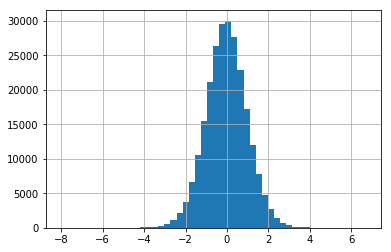

In [65]:
s = pd.Series(torch.flatten(y).cpu().numpy())
print(s.describe())
s.hist(bins=50)

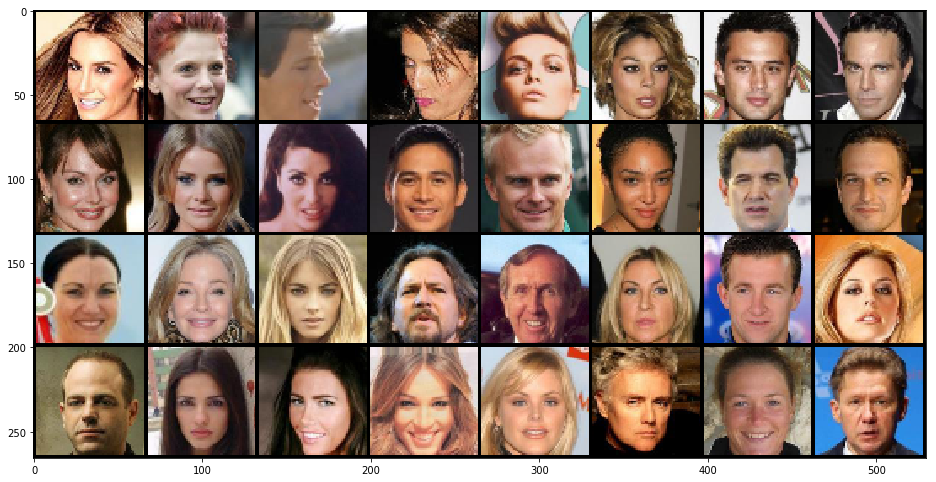

In [66]:
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(16, 16))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(utils.make_grid([x for x, _ in debug_data[:32]]))

In [67]:
model.eval()
with torch.no_grad():
    X = torch.Tensor(torch.randn((1, 64 * 64 * 3))).to(device)
    Y = model(X)
    samples = post_process(Y).cpu().numpy()

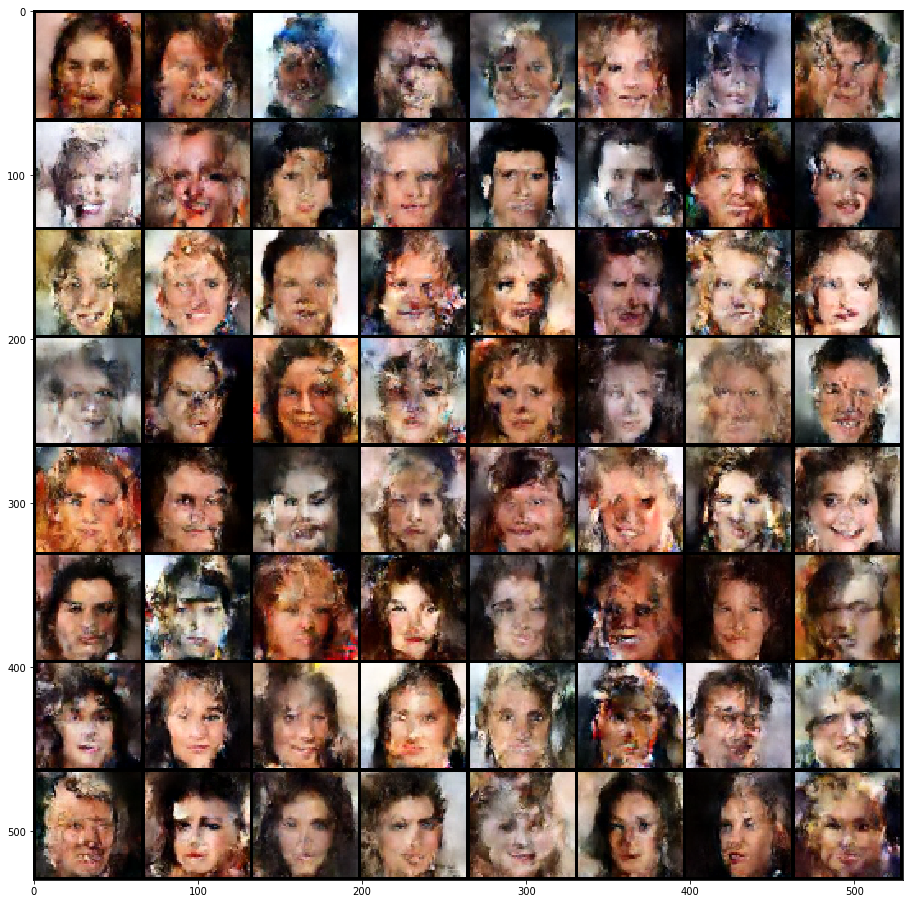

In [68]:
model.eval()

cols, rows = 8, 8
with torch.no_grad():
    X = torch.Tensor(torch.normal(torch.zeros(cols * rows, 64 * 64 * 3),
                                  torch.ones(cols * rows, 64 * 64 * 3))).to(device)
    Y = model(X)
    samples = post_process(Y).cpu()
    
imshow(utils.make_grid(samples))

# 2022-03-18

* Was able to get down to a validation loss of 3.25 bits/pixel (compared to 3.02) for the paper after 10 epochs 
   * Was going down 0.01-0.0j per epoch near the end, might have been able to squeeze a bit more with more epochs
* My debug shows that we have a distribution over Z of very close to standard
* Images still don't quite look very good.  Epoch-10, which had the 3.25 result looked poor, Epoch-9 looked a bit better (shown below):
   * Seems like it can't get some of the detailed parts (e.g. eyes) right
   * The images from the paper look better but still have similar types of corruption
   * I suspect if I could train a bit better, I might be able to get *closer* to the images from the paper (assuming some cherry pickign of images)

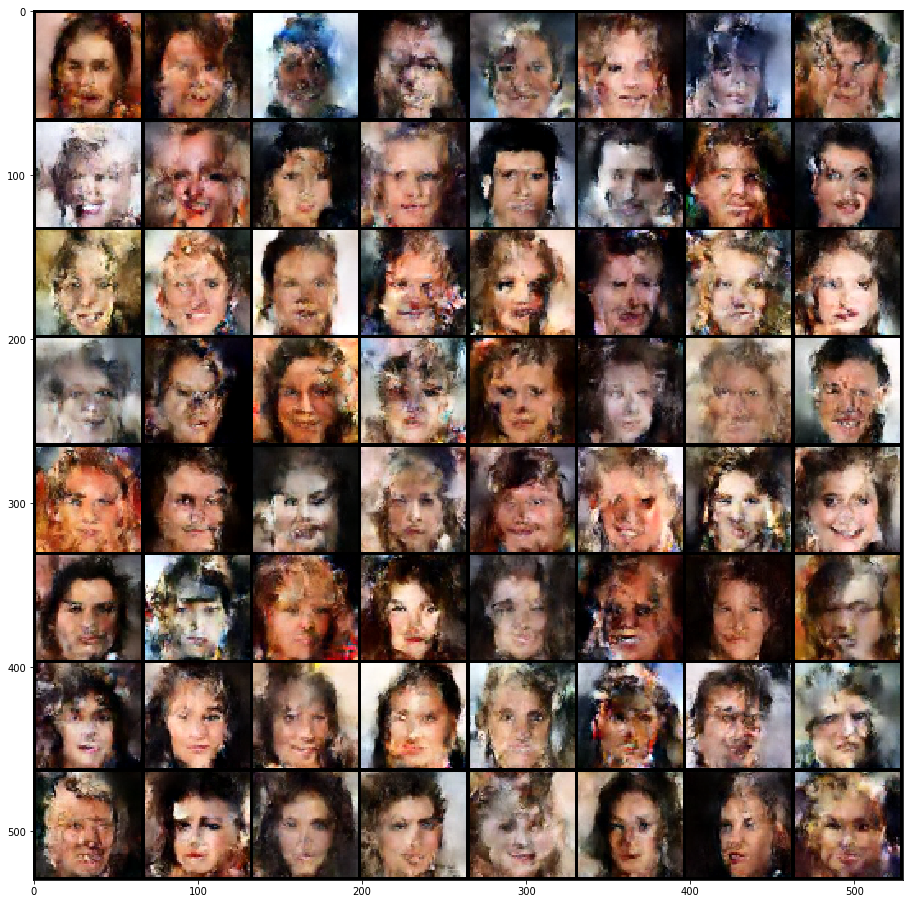

# 2022-03-17

* Trying to overfit on a couple batches of images... quality isn't great (worse than paper), getting 2.9 bits/pixel
* Forgot to add norm layers after the `Conv3x3` layers in my backbone.  It seems to make training slightly faster.
* Experimenting with weight norm too.
* All together with more training 450 epochs (vs. 300), I can get down to 2.5 bits/pixel
* Images look a bit more reasonable for me trying to overfit a couple of batches:

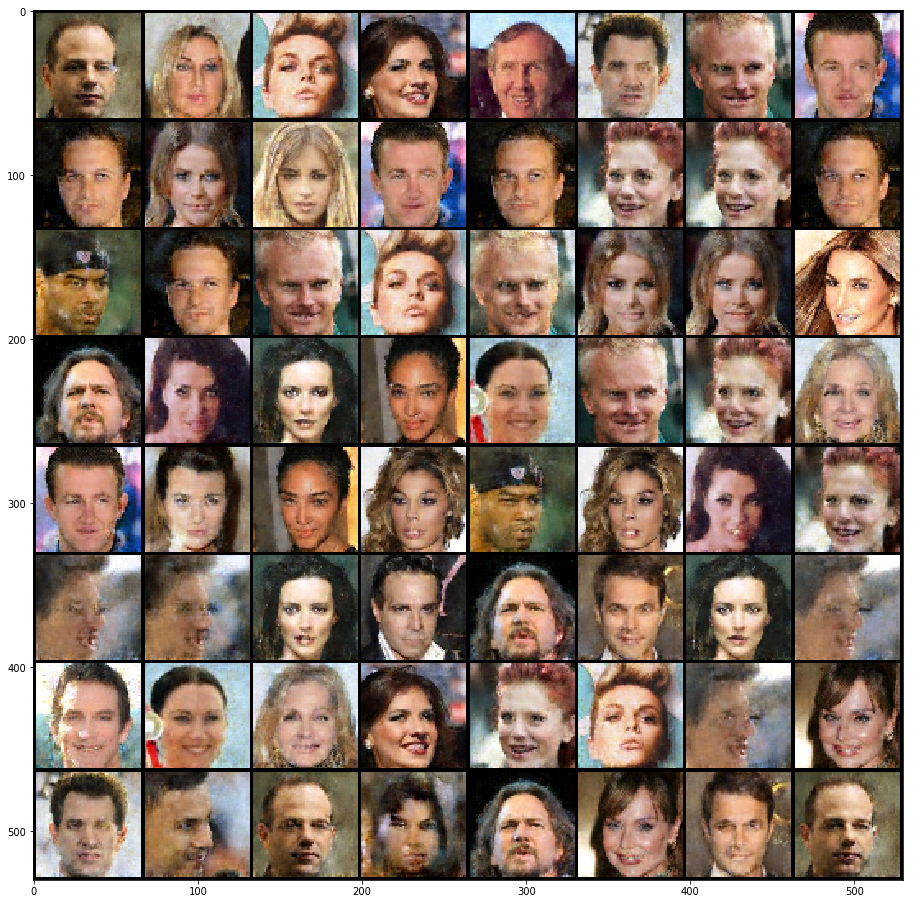